## Final Project Submission


* Student name:  Noah-John Hizon
* Student pace: part time 
* Scheduled project review date/time: 2/16 2:30 PM EST 
* Instructor name: Abhineet Kulkarni
* Blog post URL:


# Home Pricing

## Overview


The focus of this project is to provide insight for owners looking to list their homes in the housing market, informing them of the most critical elements in pricing to offer methods to increase valuation. Data regarding homes in the greater King County (Washington) area  will be utilized to compose an informed regression model. The results of this model will help realtors understand what goes into the valuation of a home, determine fair pricing, and find optimal routes of improvement for homes in their portfolio if their owners wish to sell.

## Business Problem 

Relative perception of a home's price can be a result of several factors, and home prices may skyrocket/plummet due to gentrification, overpopulation, and overall demographic shifts. On a rudimentary level though, a given property's price is determined by its features. The combination of these features may result in radically different prices. For example, homes with similar living square-footage may be priced completely different based on their location, view, or age. 

In an ever-fluctuating housing market, home owners looking to sell may be disappointed when they realize their property is worth less than they were expecting. Owners looking to increase their property valuation may have little direction/insight into the most optimal routes of home improvement. In some cases, blind financial investment into home modifications may prove to be unprofitable. 

Data from the King County housing dataset will be aggregated/summarized in order to determine the most impactful characteristics of a property's pricing. Isolating these critical features would give prospective home sellers a better idea of the make-up of their home's valuation. If it is within reason, the identified features can be improved upon in order to increase the valuation of a home.


## Data Understanding

As seen below, the imported data contains a variety of information related to the defining features of a home. Each individual field will be assessed for its contribution to a home's resulting price. Each row in the table represents a unique property and its correlated features. This makes the table easy to summarize as it eliminates the presence of duplicate properties in the dataset. 

Some columns in the dataframe are already represented in some way within other aggregate columns. For example, the 'sqft_basement' is already counted in the aggregate living space, 'sqft_living'. The data dictionary will help inform the decisions to remove any columns in order to prevent multicollinearity in our results.

In [1]:
# Importing standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, ShuffleSplit, KFold
import statsmodels.api as sm
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
from itertools import combinations


housingdata = pd.read_csv('data/kc_house_data.csv',header=0)
housingdata.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


The 'date' field (date home was sold) is removed, as homes may switch ownership on a relatively frequent basis. A more informative time-based metric to keep is 'yr_built', as the year a home was built can have an influence on the state of the its underlying construction, and the utilities present (e.g. insulation, air conditioning/heating, furnishings). 'yr_renovated' is removed for similar reasoning. While it is assumed that renovations will inherently raise a home's value, there is too much variability within the types/scale of renovations a home can go through. 

'sqft_above', 'sqft_lot', 'sqft_basement', 'sqft_living15', sqft_lot15' are removed, as they are already represented within the 'sqft_living' column, which represents the collective living area within a property. The values in 'sqft_lot' would expectedly be highly correlated with 'sqft_living' when looking at 1 floor homes.

'zipcode','lat', and 'long' are removed due to them being impossible to quantify in the context of the overall dataset. Using external tools/mapping API to infer home pricing based on location may be a potential opportunity to explore in future analyses. 

'id' is used as a unique identifier in the overall dataset, and does not have any correlation with a home's price.

In [2]:
housingdata=housingdata.drop(['id','date','yr_renovated','sqft_above','sqft_lot',
'zipcode','sqft_basement',
'lat',
'long',
'sqft_living15',
'sqft_lot15'],axis=1)


housingdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   floors       21597 non-null  float64
 5   waterfront   19221 non-null  object 
 6   view         21534 non-null  object 
 7   condition    21597 non-null  object 
 8   grade        21597 non-null  object 
 9   yr_built     21597 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 1.6+ MB


All other columns are vital in determining a home's pricing.


## Data Preparation

In the current dataframe, there is a combination of categorical/continuous variables that will need to be cleaned before the data is modeled. 

In [3]:
housingdata.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_built
0,221900.0,3,1.00,1180,1.0,NaN,NONE,Average,7 Average,1955
1,538000.0,3,2.25,2570,2.0,NO,NONE,Average,7 Average,1951
2,180000.0,2,1.00,770,1.0,NO,NONE,Average,6 Low Average,1933
3,604000.0,4,3.00,1960,1.0,NO,NONE,Very Good,7 Average,1965
4,510000.0,3,2.00,1680,1.0,NO,NONE,Average,8 Good,1987


The categorical values, 'condition','grade','view', and 'waterfront' will need to be label encoded in order to better evaluate their columns. Detailed ranking definitions for each column were found through the King County Assessor website, and were used to assign numerical values to the values via the use of a dictionary. 

For 'condition', this variable appears to have a 5-point scale from 'Poor' to 'Very Good'. This will be encoded into numerical values spanning 1-5.

Similarly 'grade' seems to have a wider scale with 11 points, 'Poor' being the worst ranking, and 'Mansion' being the highest. It seems like 'grade' is given a numerical value despite having several qualitative features comprising the overall rank, implying that there might be some collinearity with square foot living. This will be encoded with the range 1-11.

'view' seems to have 4 points in its scale. If there is no view of any natural features, that home is given a value of 'NONE'. If there is a view present, the value is assigned as either 'FAIR', 'GOOD', or 'EXCELLENT'. This is encoded on a scale from 0-3 in the new dataset. This column also had null values; it is safe to assume that if a value is not present, the property has no observable view. 

Waterfront is a binary variable indicating whether the home lies on the water (1) or not (0). Because this variable has little variation in its points, it might be difficult to determine any sort of correlation with price through this feature.
 
The existing columns are then mapped according to their inferred dictionary values (below), values being inputted into new columns in the table. The table data then has its null column values filled with zero. Previous columns are then dropped. 

In [4]:
dictcond={'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
dictgrade={'3 Poor':1,'4 Low':2,'5 Fair':3,'6 Low Average':4,'7 Average':5,
           '8 Good':6,'9 Better':7,'10 Very Good':8,'11 Excellent':9,'12 Luxury':10,'13 Mansion':11}
dictview={'EXCELLENT':3,'GOOD':2,'FAIR':1,'NONE':0}
dictwater={'NO':0,'YES':1}

In [5]:
housingdata['conditioned']=housingdata['condition'].map(dictcond)
housingdata['graded']=housingdata['grade'].map(dictgrade)
housingdata['viewed']=housingdata['view'].map(dictview)
housingdata['water']=housingdata['waterfront'].map(dictwater)

In [6]:
housingdata['conditioned']=housingdata['conditioned'].fillna(0)
housingdata['graded']=housingdata['graded'].fillna(0)
housingdata['viewed']=housingdata['viewed'].fillna(0)
housingdata['water']=housingdata['water'].fillna(0)
housingdata['yr_built']=housingdata['yr_built'].fillna(0)

In [7]:
housingnumer=housingdata.drop(['waterfront','view','condition','grade'],axis=1)

housingnumer.head(10)

,price,bedrooms,bathrooms,sqft_living,floors,yr_built,conditioned,graded,viewed,water
0,221900.0,3,1.00,1180,1.0,1955,3,5,0.0,0.0
1,538000.0,3,2.25,2570,2.0,1951,3,5,0.0,0.0
2,180000.0,2,1.00,770,1.0,1933,3,4,0.0,0.0
3,604000.0,4,3.00,1960,1.0,1965,5,5,0.0,0.0
4,510000.0,3,2.00,1680,1.0,1987,3,6,0.0,0.0
5,1230000.0,4,4.50,5420,1.0,2001,3,9,0.0,0.0
6,257500.0,3,2.25,1715,2.0,1995,3,5,0.0,0.0
7,291850.0,3,1.50,1060,1.0,1963,3,5,0.0,0.0
8,229500.0,3,1.00,1780,1.0,1960,3,5,0.0,0.0
9,323000.0,3,2.50,1890,2.0,2003,3,5,0.0,0.0


The data is now prepped for modeling. For this project, the plan is to use multiple linear regression in order to collectively assess the effect of all relevant variables on sale price. We have multiple predictors that all individually affect the 'price' variable, so the magnitude of each will be crucial to understand. Regression will also determine the validity of the relationships between predictor/outcome variables through coefficients in the model's results.

Before creating the model, scatter plots are shown for each predictor vs. price to visually identify any stark trends.

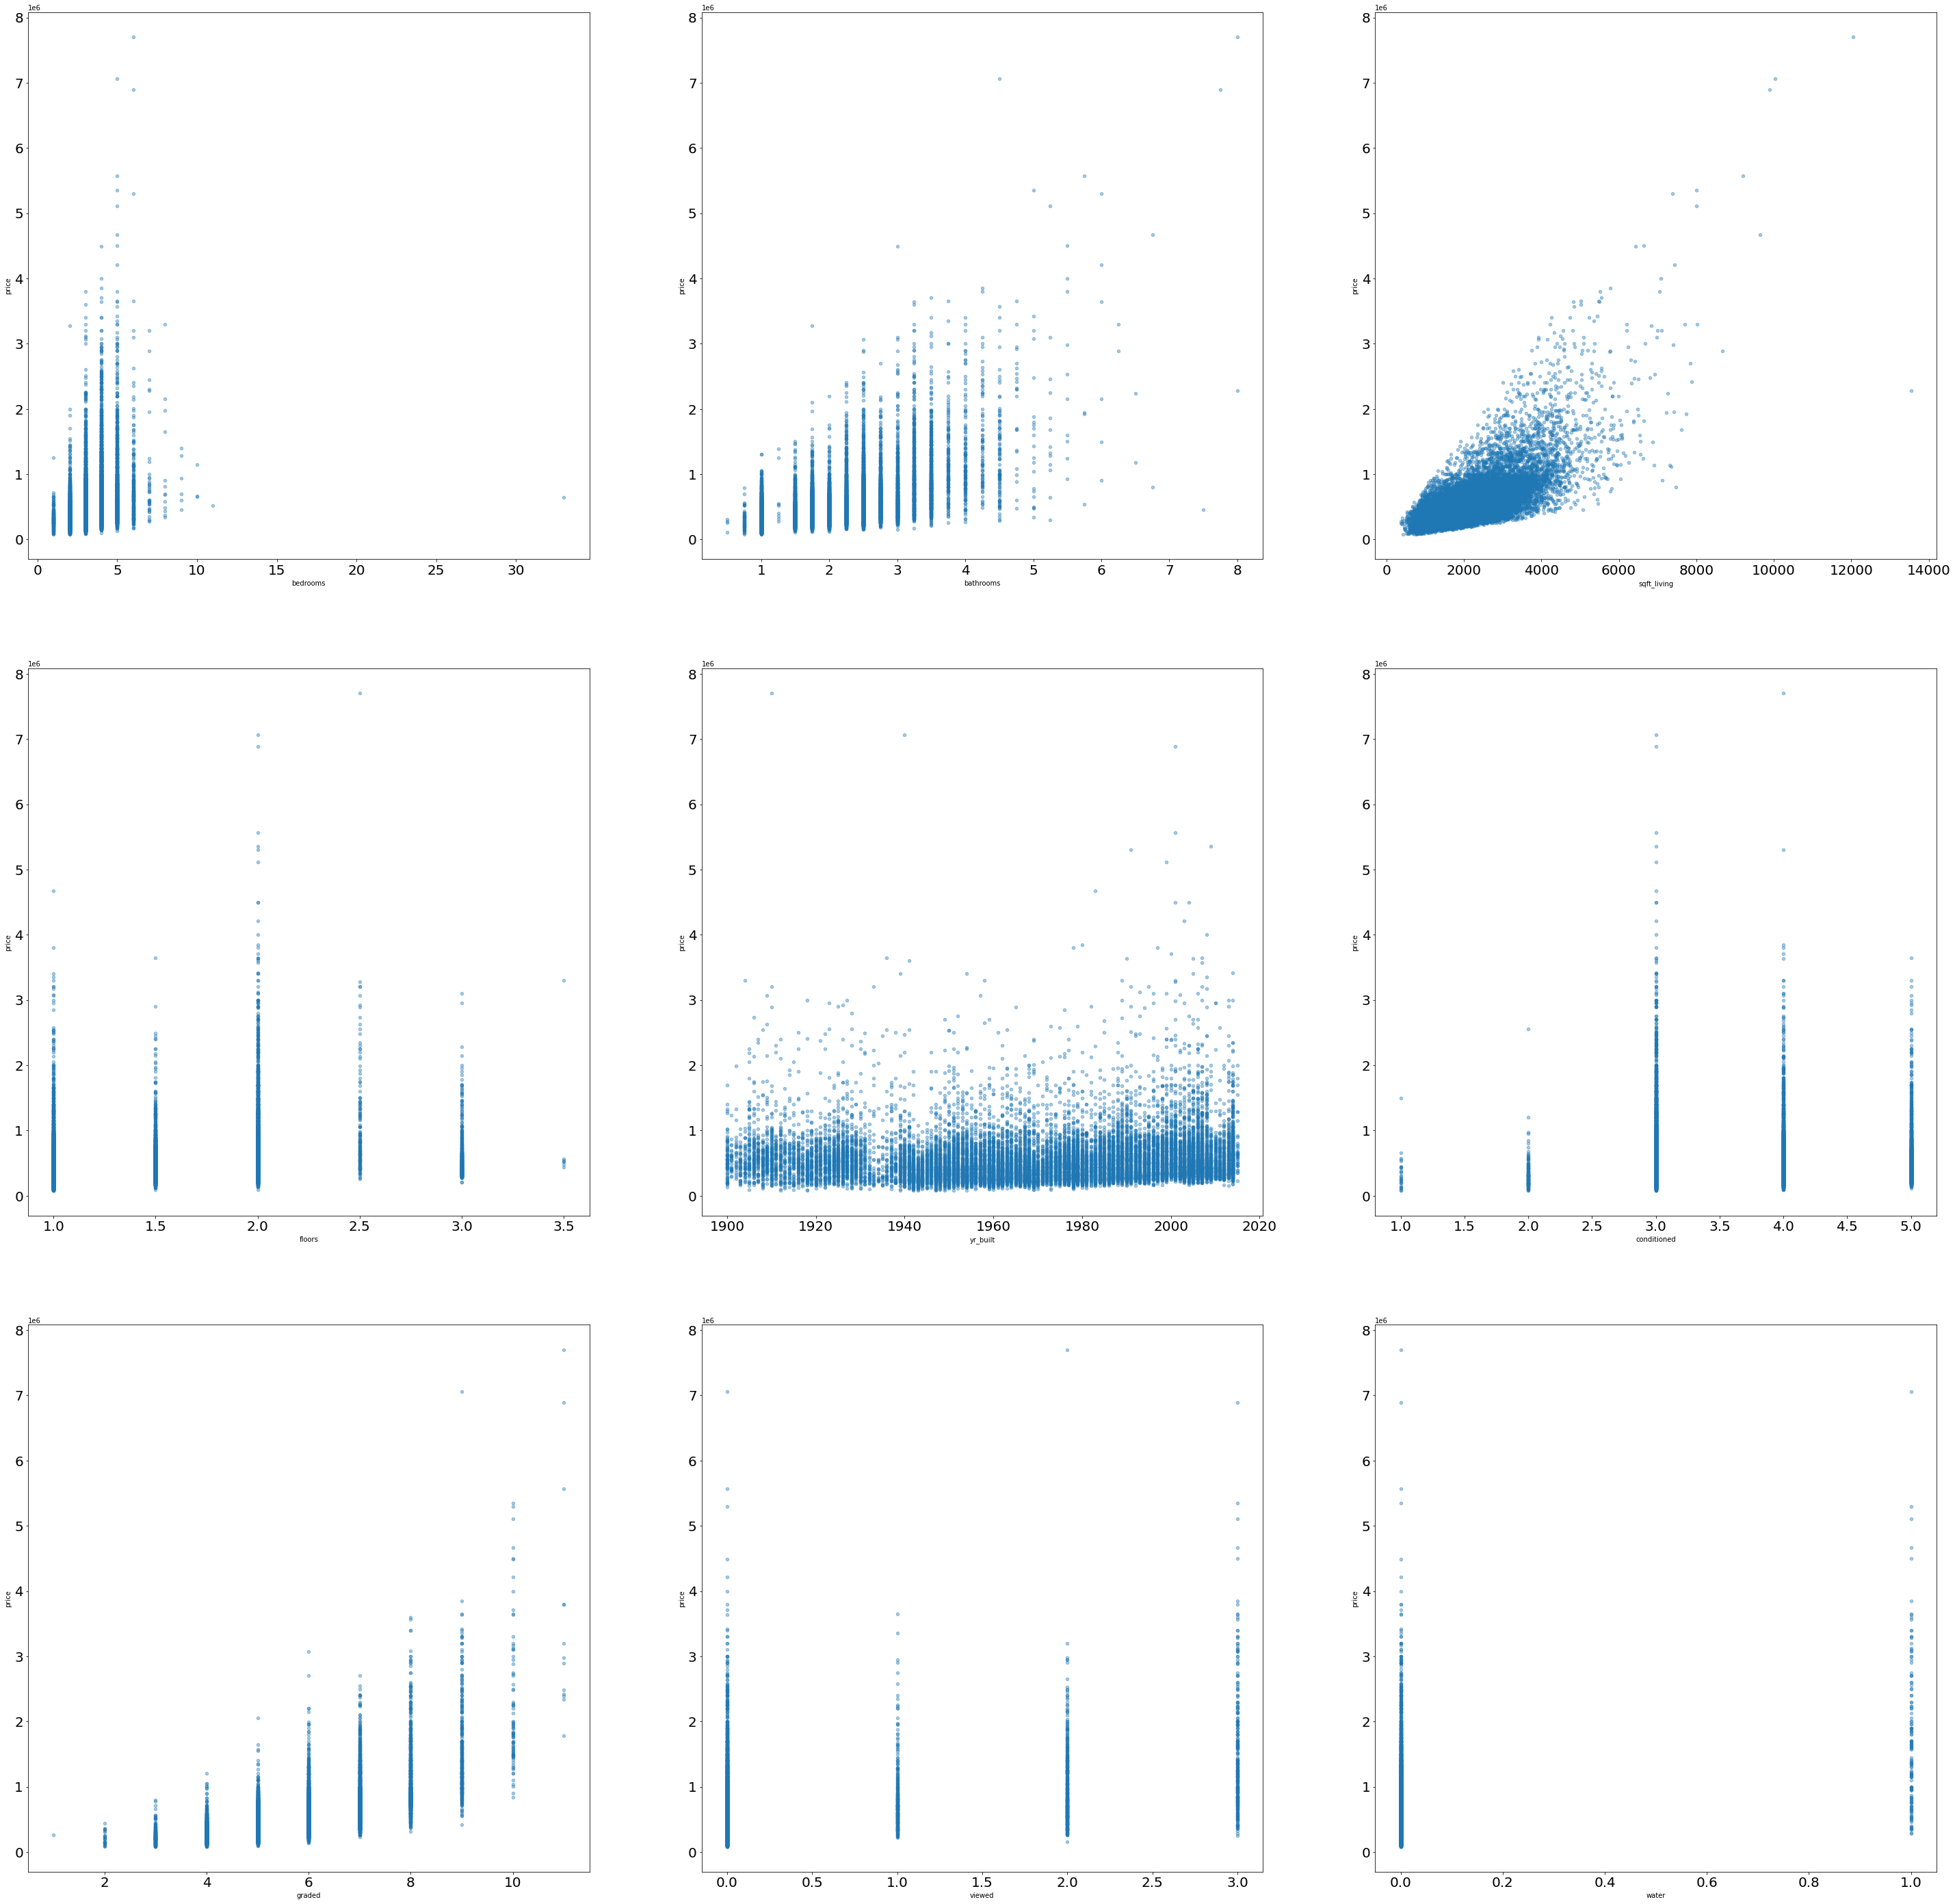

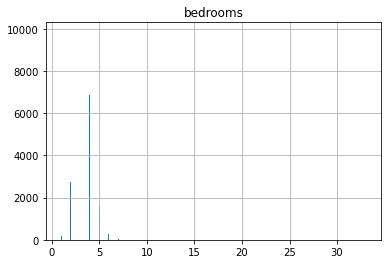

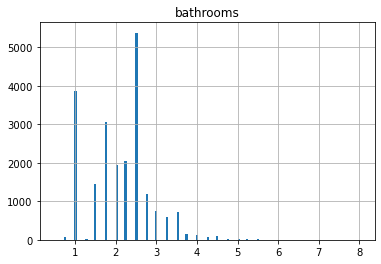

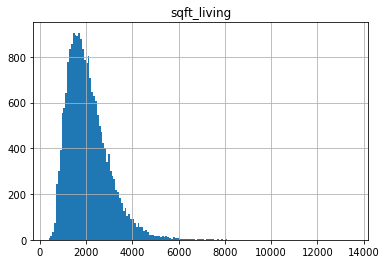

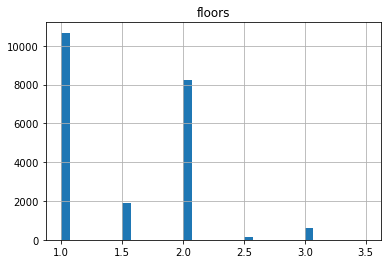

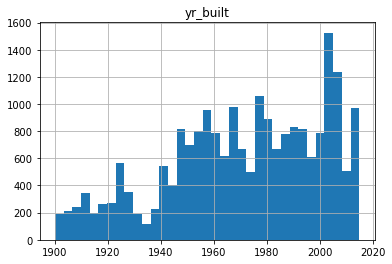

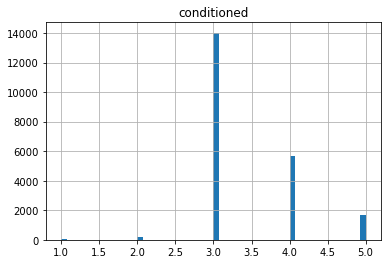

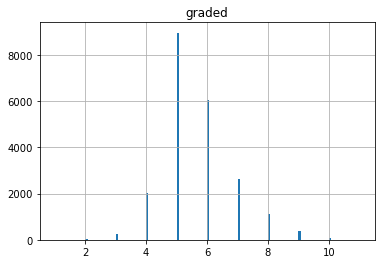

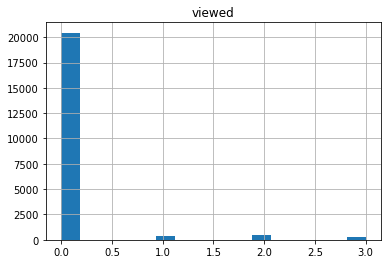

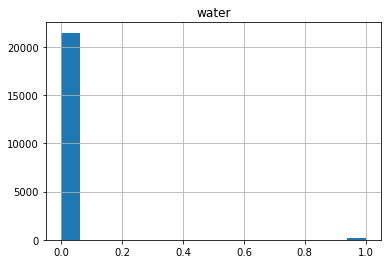

In [8]:
fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(50,50))
for col, ax in zip(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'yr_built', 'conditioned', 'graded','viewed','water'], axes.flatten()):
    housingnumer.plot(kind='scatter', x=col, y='price', ax=ax, alpha=.4, fontsize=20)
    housingnumer.hist(column=col, bins='auto')

Upon first glance, some of the variables show a linear trend when plotted against 'price', particularly 'bedrooms', 'bathrooms', and 'sqft_living'.  The charts also discerned variables that were either categorical or continuous, and the distribution of their contents. The more segmented scatter charts are categorical columns. 

Initially, it was assumed that the more 'floors' a home had, the higher it would be priced. Looking at the scatter plots show that this is not the case. There is a high amount of variability within the lower floor counts. Some entries within 'floors' column are not whole integers. This implies that some houses might features that aren’t considered floors in a strict sense, like attics or guest houses. 

Similarly, the 'bathrooms' column is incremented by .25 in some cases. This implies that homes evaluate bathroom count based on features present. A full bathroom (counted as 1) is likely one that contains a shower, toilet, and sink. 

There might be a linear correlation between 'viewed' (view),'conditioned' (condition), and 'graded' (grade), against 'price', but variability is observed in the higher values within each column.

'yr_built' also contains a lot of variability, but the bottom of the spread shows that the minimum price of a newly built home is slightly higher than older homes, expectedly.

## Data Modeling

Now that the relevant columns are cleaned, modeling with a focus on 'price' can begin. First, a heat map is created to show the correlation between all of our variables.

<AxesSubplot:>

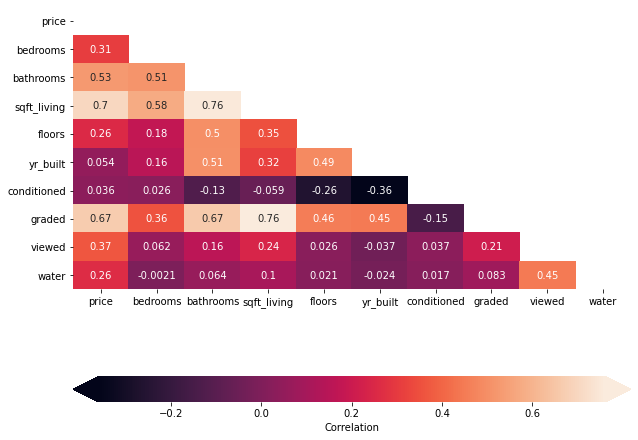

In [9]:
correlation=housingnumer.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    data=correlation,
    mask=np.triu(np.ones_like(correlation, dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

It seems as if 'sqft_living', 'graded', 'viewed', and 'bathrooms' all have some sort of correlation with 'price' seeing as their values of correlation are at least over .35. 

Within each of the individual predictors, it seems like there might be some columns that might have correlation to each other, which could prove to be a problem in the linearity of our model. In later models we will refine and evaluate these tendencies.

### First Model


The first model will be created with variables that had the highest correlation with 'price'.

In [10]:
baselinemodel=LinearRegression()

housingfirstmodel=housingnumer[['graded','sqft_living','bathrooms','viewed','price']]
housingfirstmodel.head()

,graded,sqft_living,bathrooms,viewed,price
0,5,1180,1.00,0.0,221900.0
1,5,2570,2.25,0.0,538000.0
2,4,770,1.00,0.0,180000.0
3,5,1960,3.00,0.0,604000.0
4,6,1680,2.00,0.0,510000.0


The data is modeled with the OLS (ordinary least squares) method, which involves minimizing the sum of the squared residuals when plotting the predictors against the outcome variable, and is typically used in linear regression to identify unknown parameters.

In [11]:
outcome='price'
columns=['viewed','bathrooms','sqft_living','graded']
predictors='+'.join(columns)
f=outcome+'~'+predictors
model1=smf.ols(formula=f,data=housingfirstmodel).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     7282.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:37:57   Log-Likelihood:            -2.9817e+05
No. Observations:               21597   AIC:                         5.963e+05
Df Residuals:                   21592   BIC:                         5.964e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.566e+05   8881.893    -40.150      0.000   -3.74e+05   -3.39e+05
viewed        1.52e+05   3511.805     43.283      0.000    1.45e+05    1.59e+05
bathrooms   -3.163e+04   3317.616     -9.535      0.000   -3.81e+04   -2.51e+04
sqft_living   184.4914      3.231     57.092      0.000     178.157     190.825
graded       9.966e+04   2202.683     45.245      0.000    9.53e+04    1.04e+05
==============================================================================
Omnibus:                    16441.507   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1065837.173
Skew:                           3.109   Prob(JB):                         0.00
Kurtosis:                      36.849   Cond. No.                     1.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The initial model has a very high Jarque-Bera coefficient, which implies a lack of normality within our continuous variables, which we can improve on in later iterations.

The model coefficient that used to assess performance is the R-squared coefficient (top-right corner of the summary), which describes what percent of the dependent variable is described by the included predictors. 

Our goal with this iterative process will be to maximize this value/keep this value high, while reducing the Jarque-Bera coefficient, Kurtosis (sharpness of a frequency distribution curve). The more variables are added to the model will inherently increase the R2 coefficient, but we don't want the model to be over-explained/over-fitted through the addition of new variables.

Housing Dataset - Regression Analysis for Price vs. graded


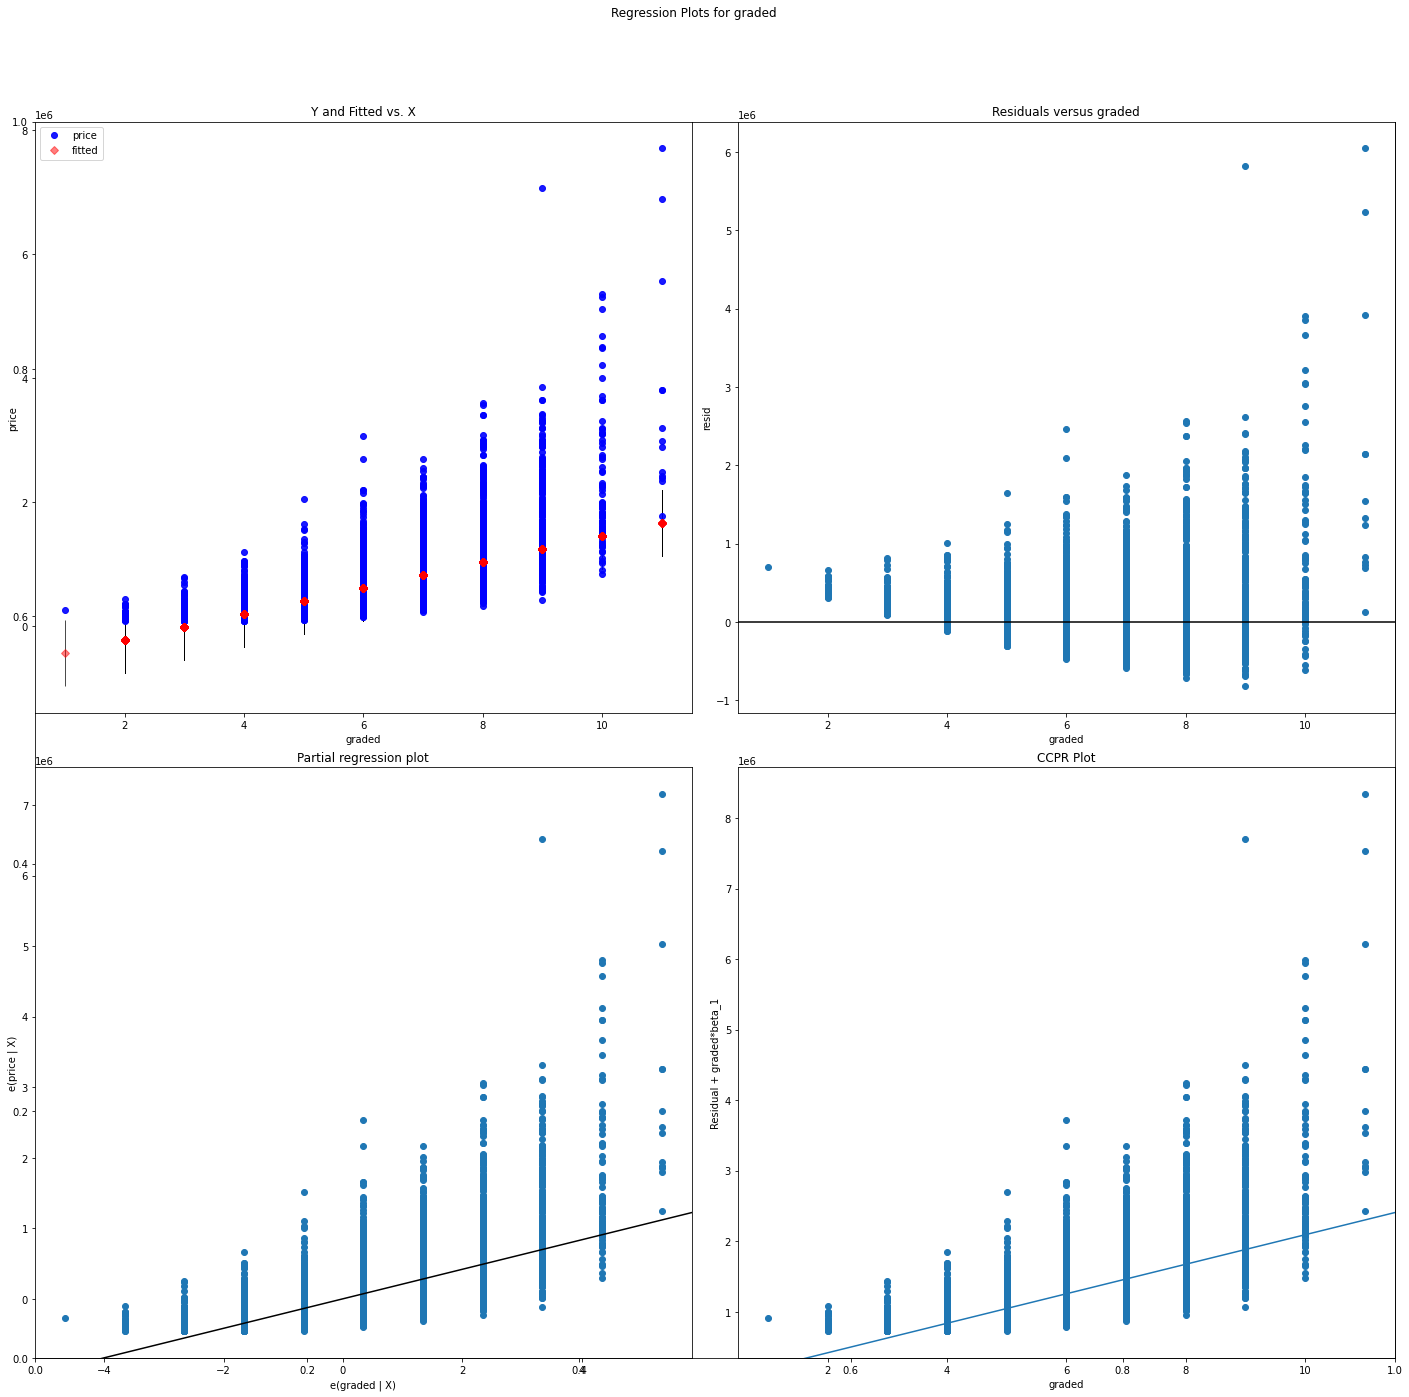

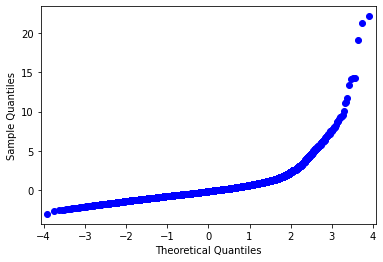

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. sqft_living


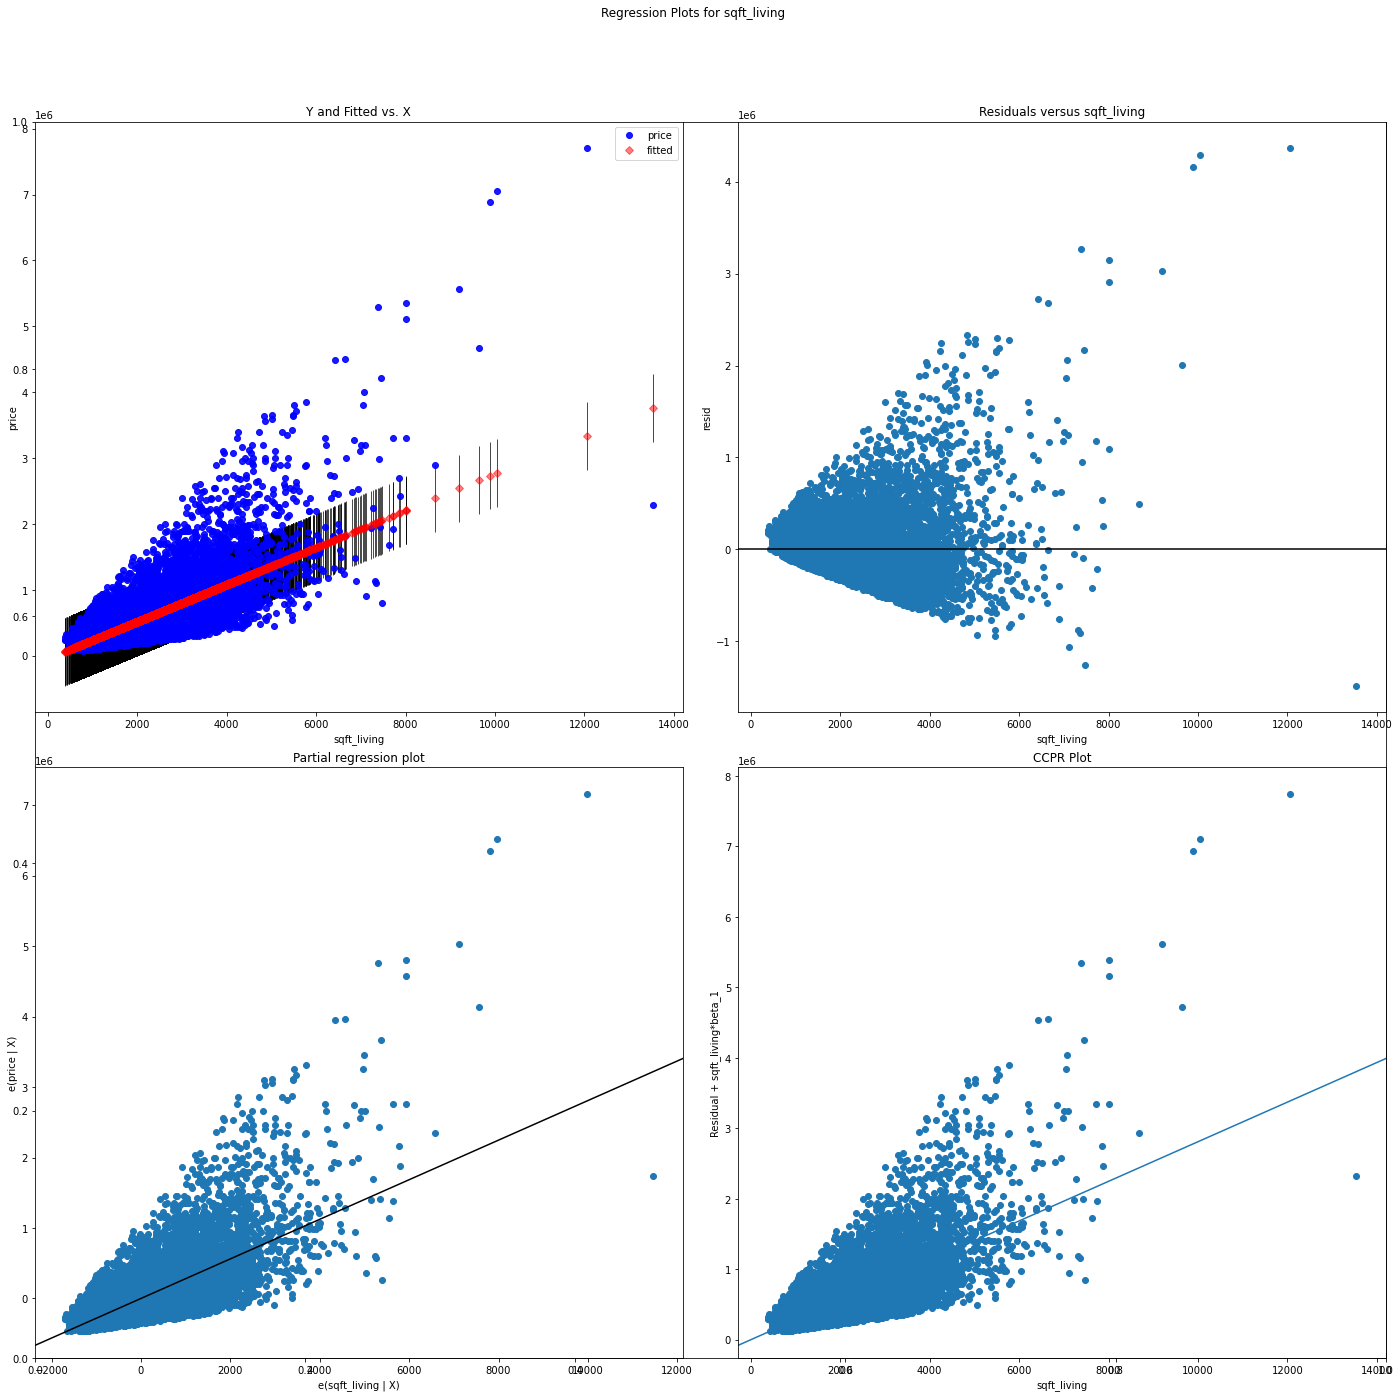

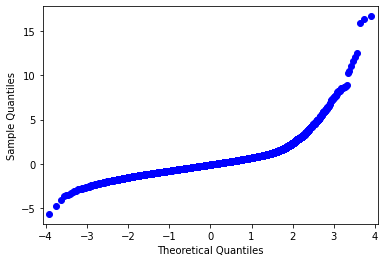

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. bathrooms


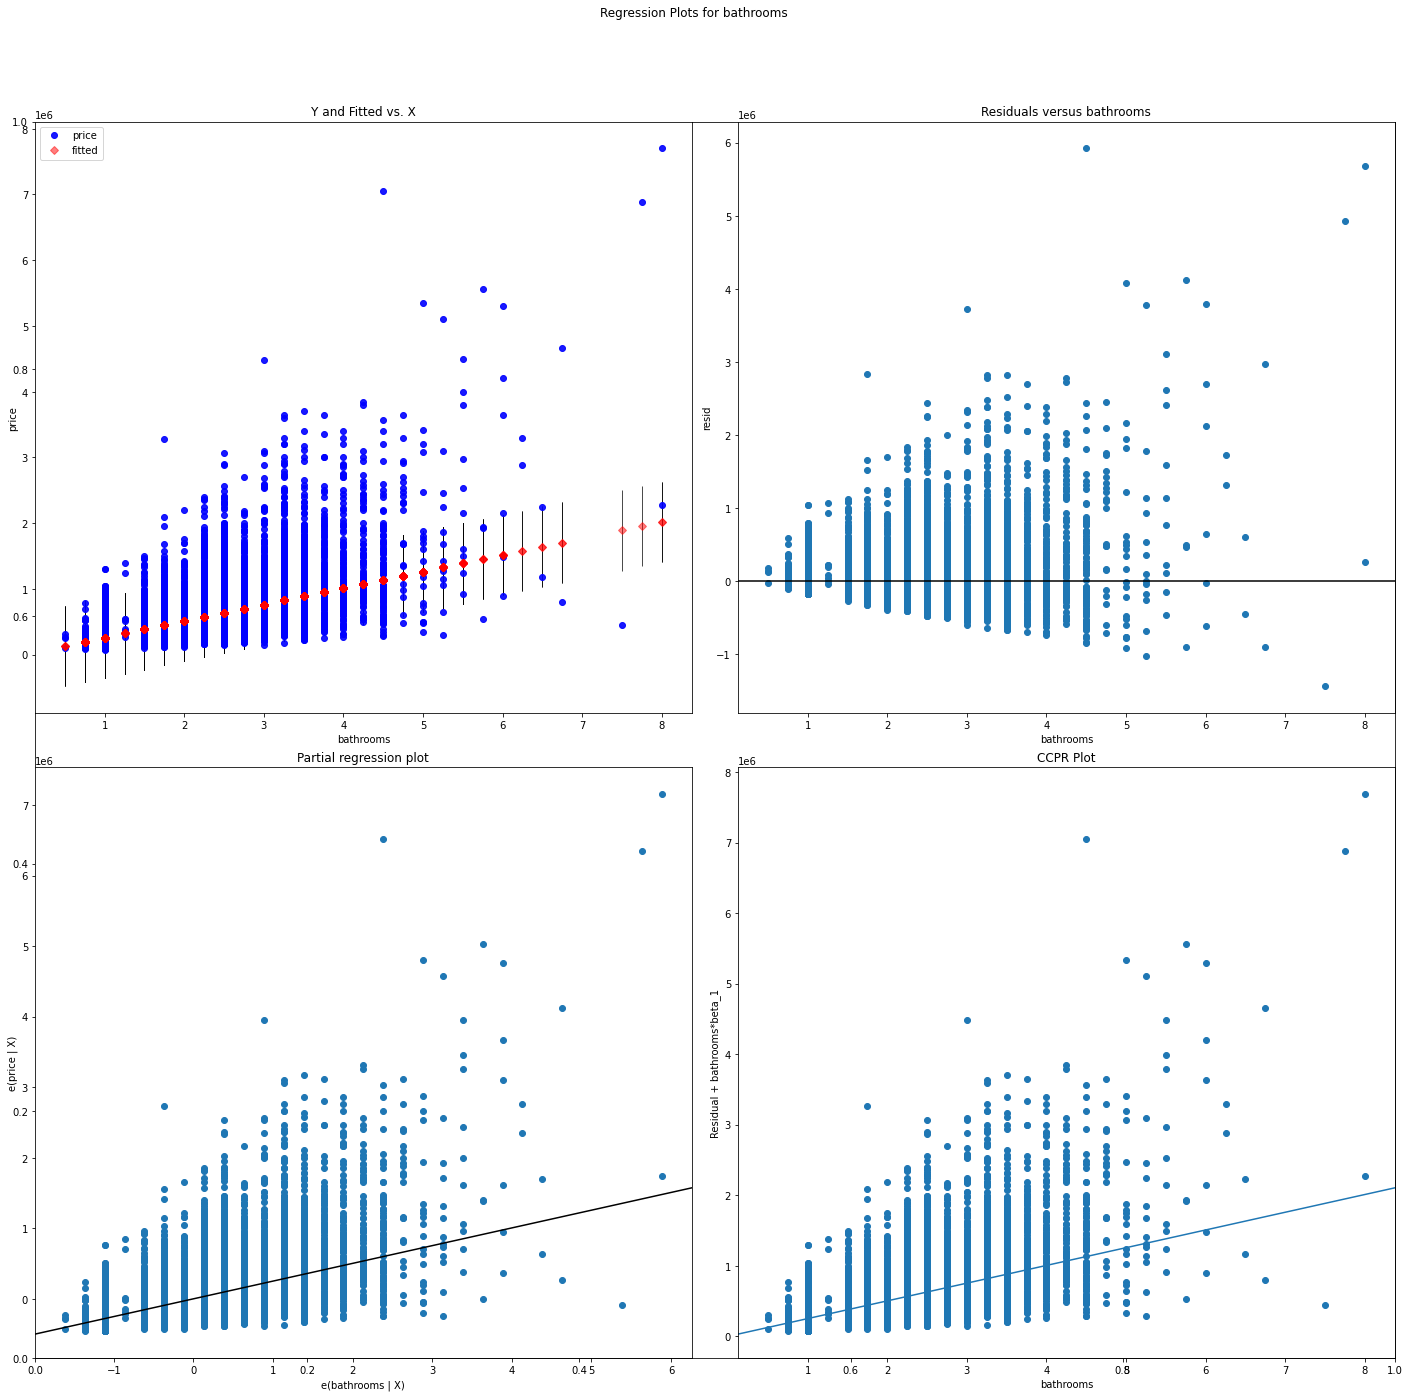

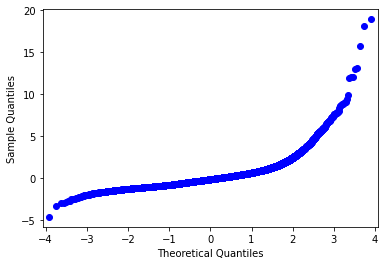

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. viewed


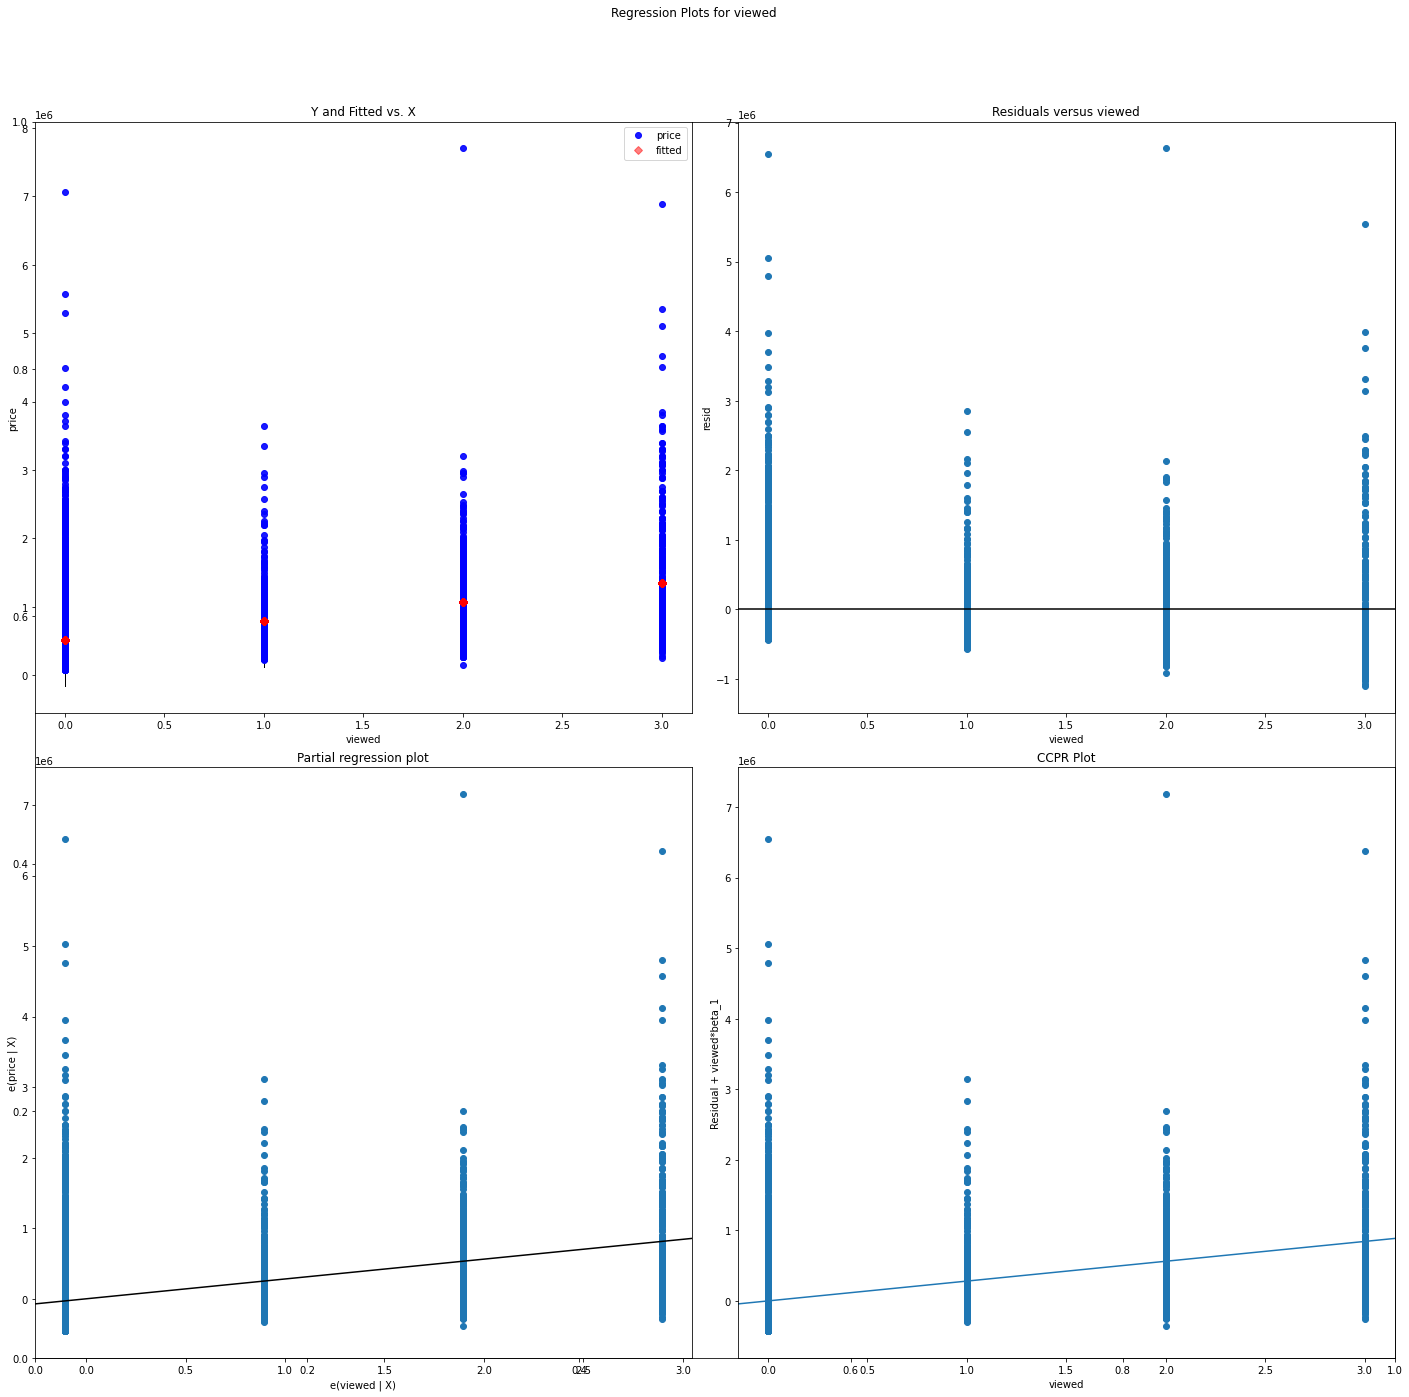

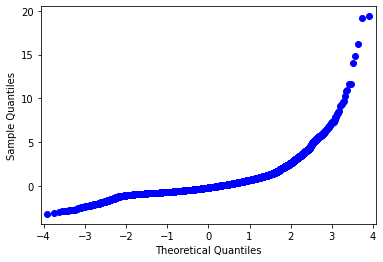

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. price


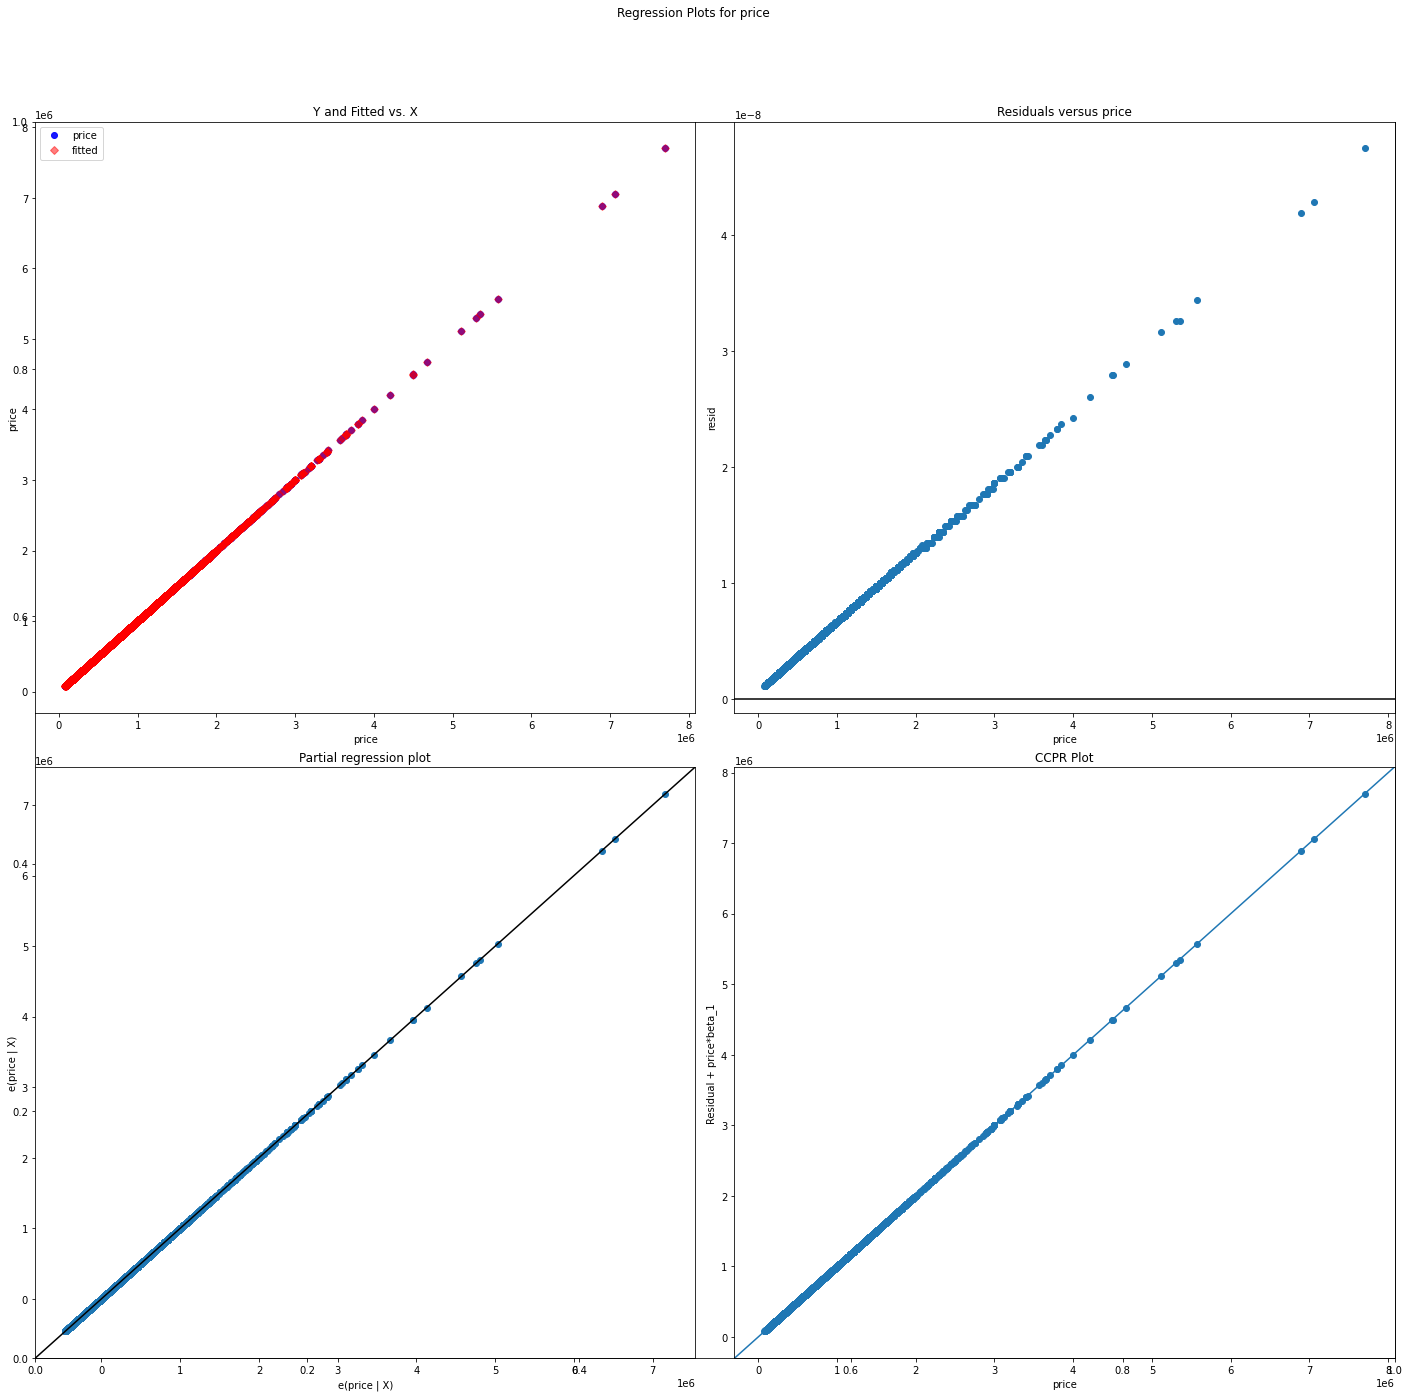

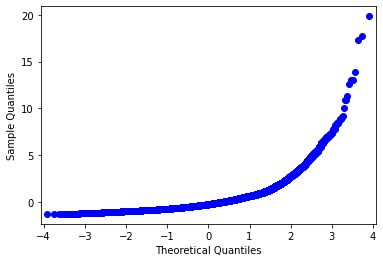

Press enter to continue


In [12]:
results=[]
for idx, column in enumerate(housingfirstmodel.columns):
    print('Housing Dataset - Regression Analysis for Price vs. {}'.format(column))
    f=f'price~{column}'
    model=smf.ols(formula=f, data=housingfirstmodel).fit()
    fig, axes = plt.subplots(figsize=(20,20))
    fig=sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig=sm.graphics.qqplot(model.resid, dist=stats.norm, fit=True)
    plt.show()
    results.append([column, model.rsquared, model.params[0],model.pvalues[1], sms.jarque_bera(model.resid)[0]])
    input('Press enter to continue')

Looking at the plotted residuals, there appears to be a good amount of work  required with the continuous and categorical variables in order to improve our model results. 

The Q-Q (quantile-quantile) plot shows that our continuous data is not normally distributed. Normally distributed variables would have a plotted straight line, at a 45 degree angle. 

This is also seen through our residuals plot, which would look more evenly distributed amongst the x-axis if the data was normal. Currently, it looks as there is a lot of heteroscedasticity within the plotted residuals, having a wider spread on the higher X values.

### Second Model

In this model, transformations on the continuous variables will be performed in order to get them to better fit the assumptions of normality. 
In this case, log transformations are applied to the 'sqft_living' and 'price' variables. As a note, when it comes to our interpreting our eventual results, our resulting outcome metric value for price is actually the power 'e' is raised to. Taking the inverse of the natural log value gives us our actual calculated 'price'. 


In [13]:
housingmodel2=housingfirstmodel.copy()

housingmodel2cont=housingmodel2[['sqft_living','price']]
housingmodel2cat=housingmodel2[['viewed','bathrooms','graded']]

for col in housingmodel2cont.columns:
    housingmodel2cont[col]=housingmodel2cont[col].map(lambda x: np.log(x))

housingmodel2=pd.concat([housingmodel2cont,housingmodel2cat],axis=1)

<ipython-input-13-a8ddab344ffc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housingmodel2cont[col]=housingmodel2cont[col].map(lambda x: np.log(x))


In [14]:
outcome='price'
columns=['viewed','bathrooms','sqft_living','graded']
predictors='+'.join(columns)
f=outcome+'~'+predictors
model2=smf.ols(formula=f,data=housingmodel2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     7055.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:38:18   Log-Likelihood:                -7764.9
No. Observations:               21597   AIC:                         1.554e+04
Df Residuals:                   21592   BIC:                         1.558e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       8.8236      0.062    142.979      0.000       8.703       8.945
viewed          0.1578      0.005     31.276      0.000       0.148       0.168
bathrooms      -0.0112      0.005     -2.302      0.021      -0.021      -0.002
sqft_living     0.4136      0.010     41.921      0.000       0.394       0.433
graded          0.1959      0.003     63.202      0.000       0.190       0.202
==============================================================================
Omnibus:                       57.620   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.383
Skew:                           0.097   Prob(JB):                     1.55e-12
Kurtosis:                       2.848   Cond. No.                         259.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this model, our R-squared value went down slightly, but our Jarque-Bera constant and Kurtosis value  went down greatly. 

Housing Dataset - Regression Analysis for Price vs. sqft_living


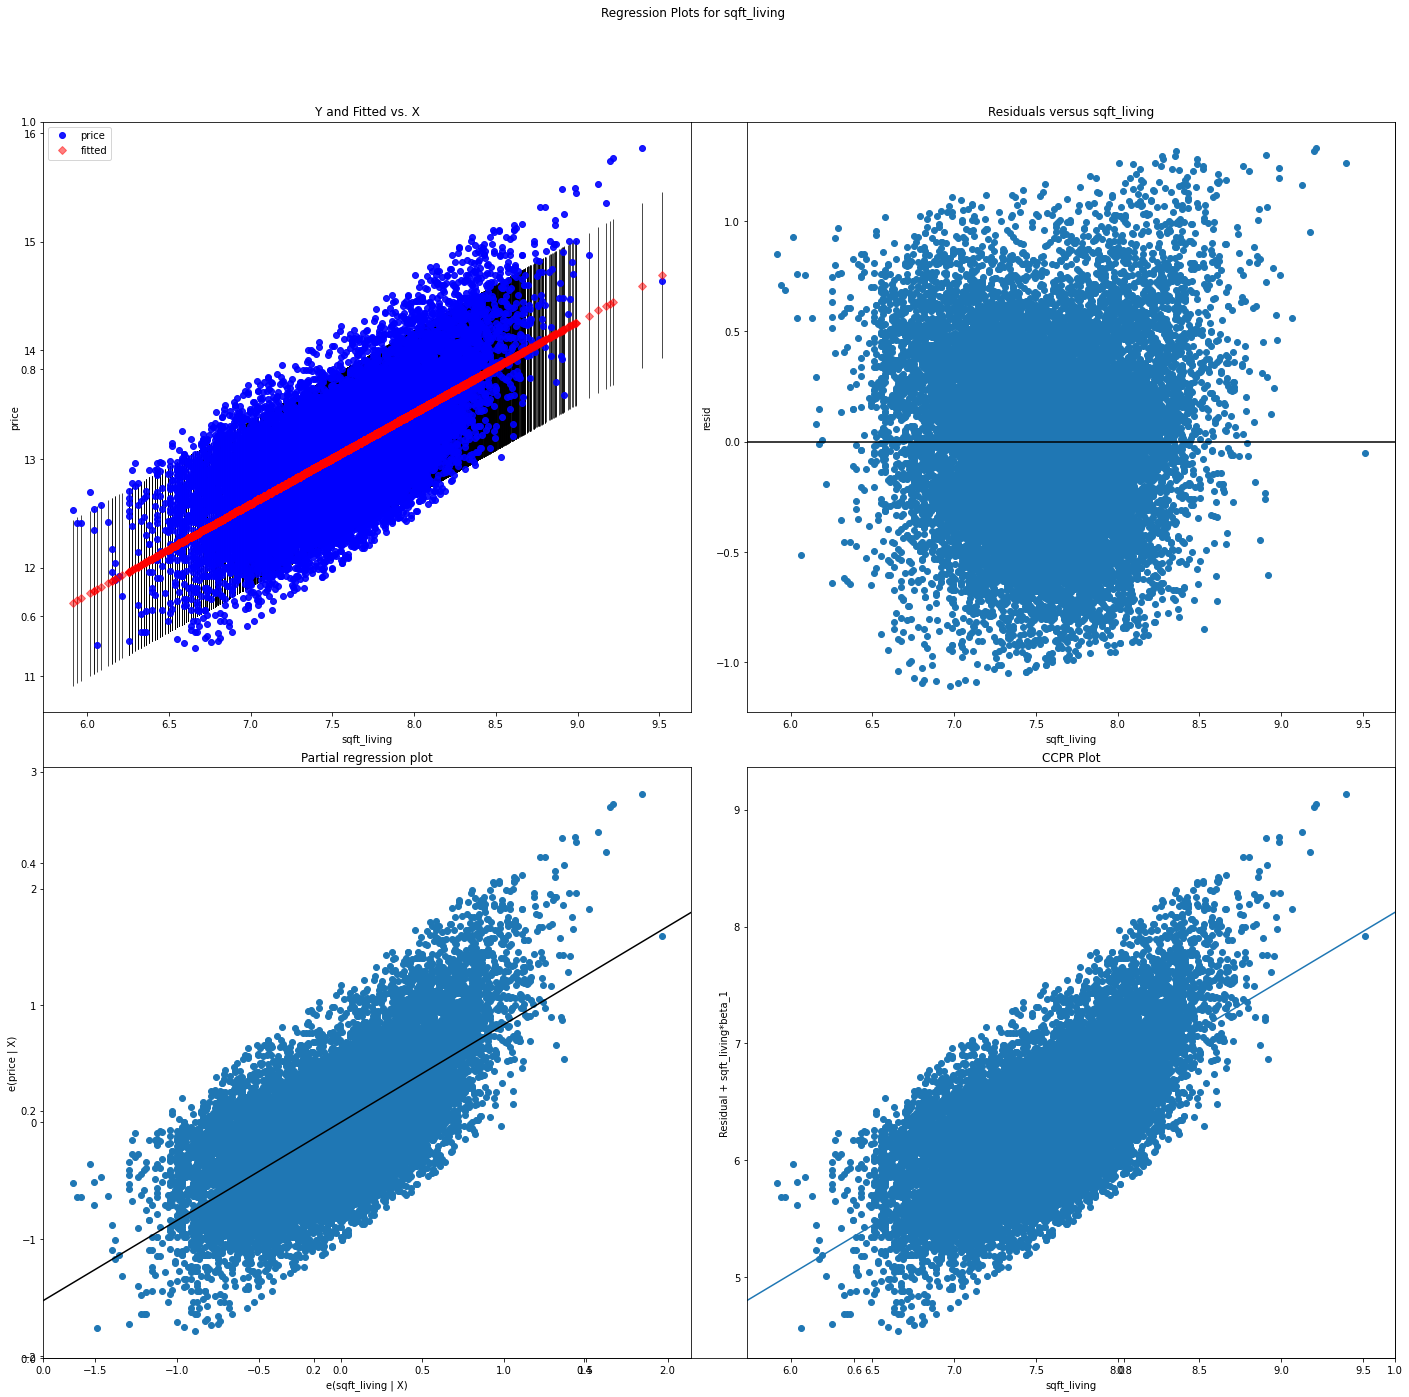

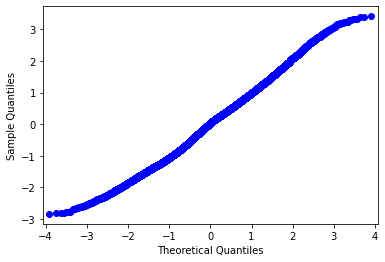

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. price


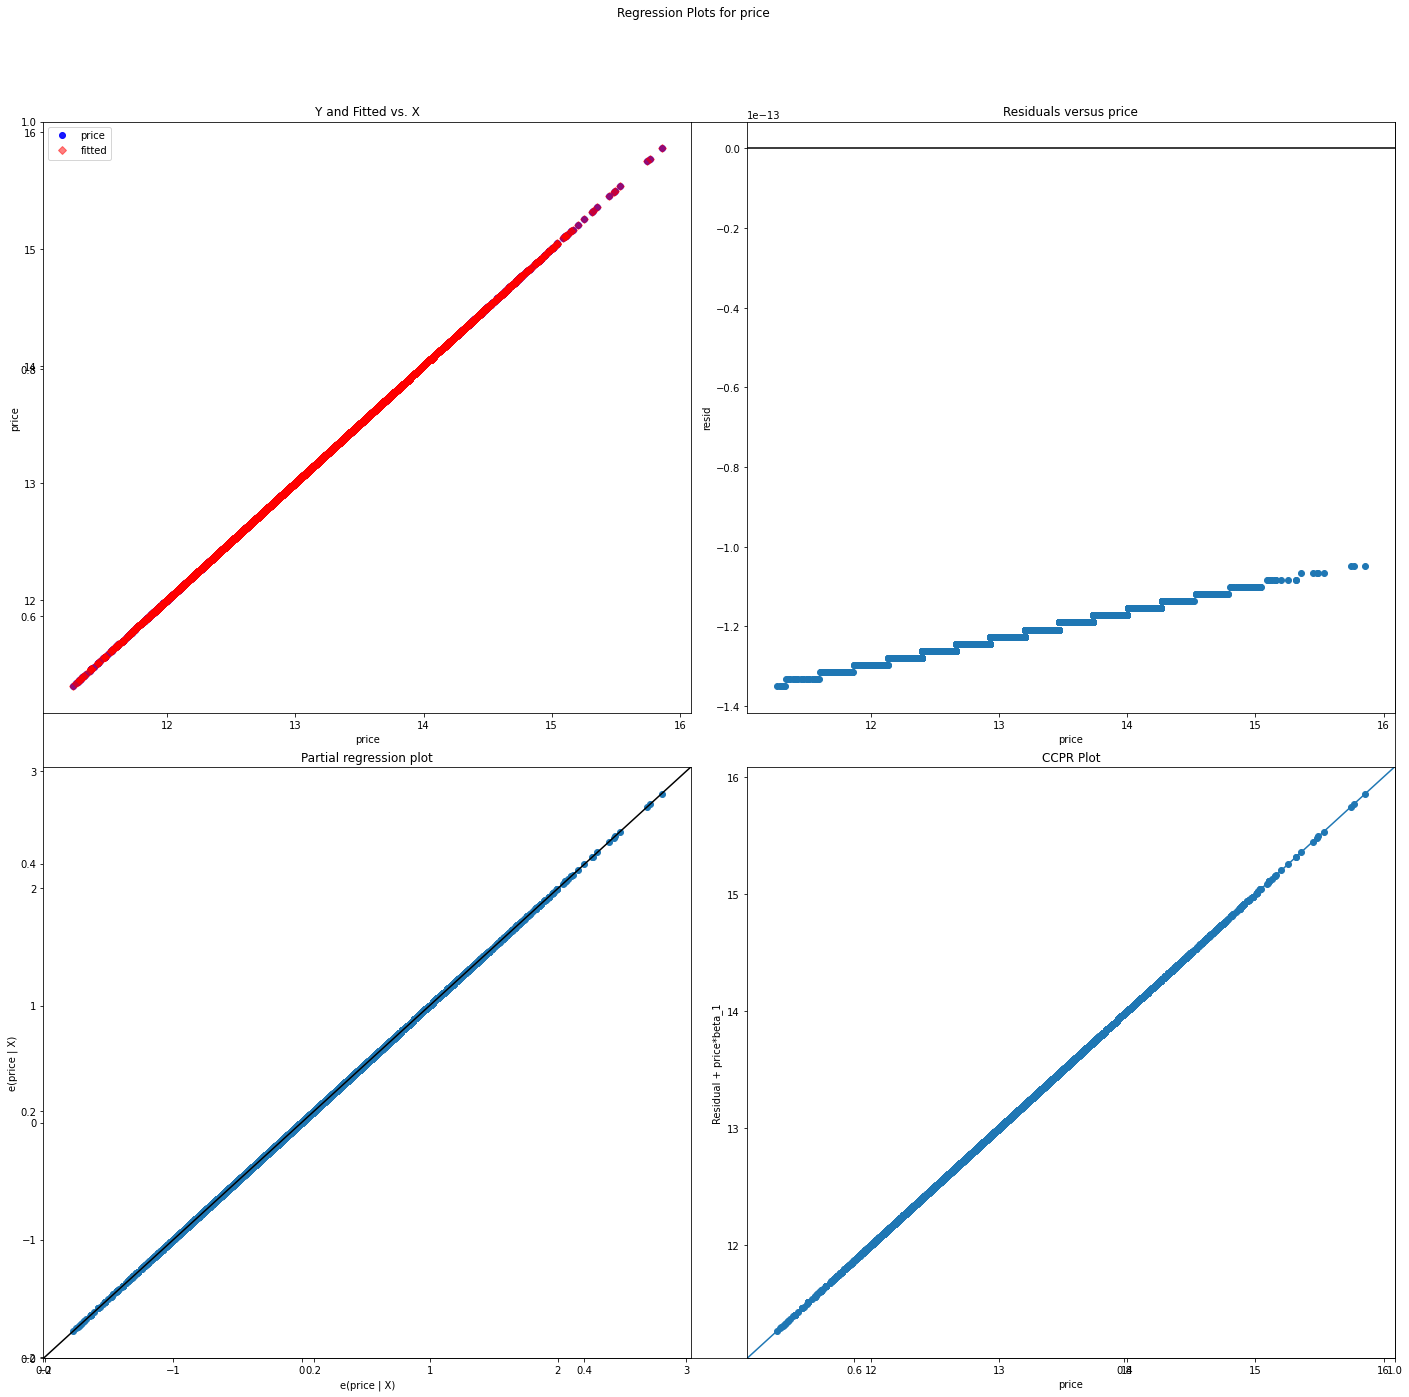

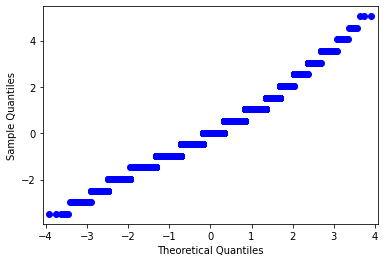

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. viewed


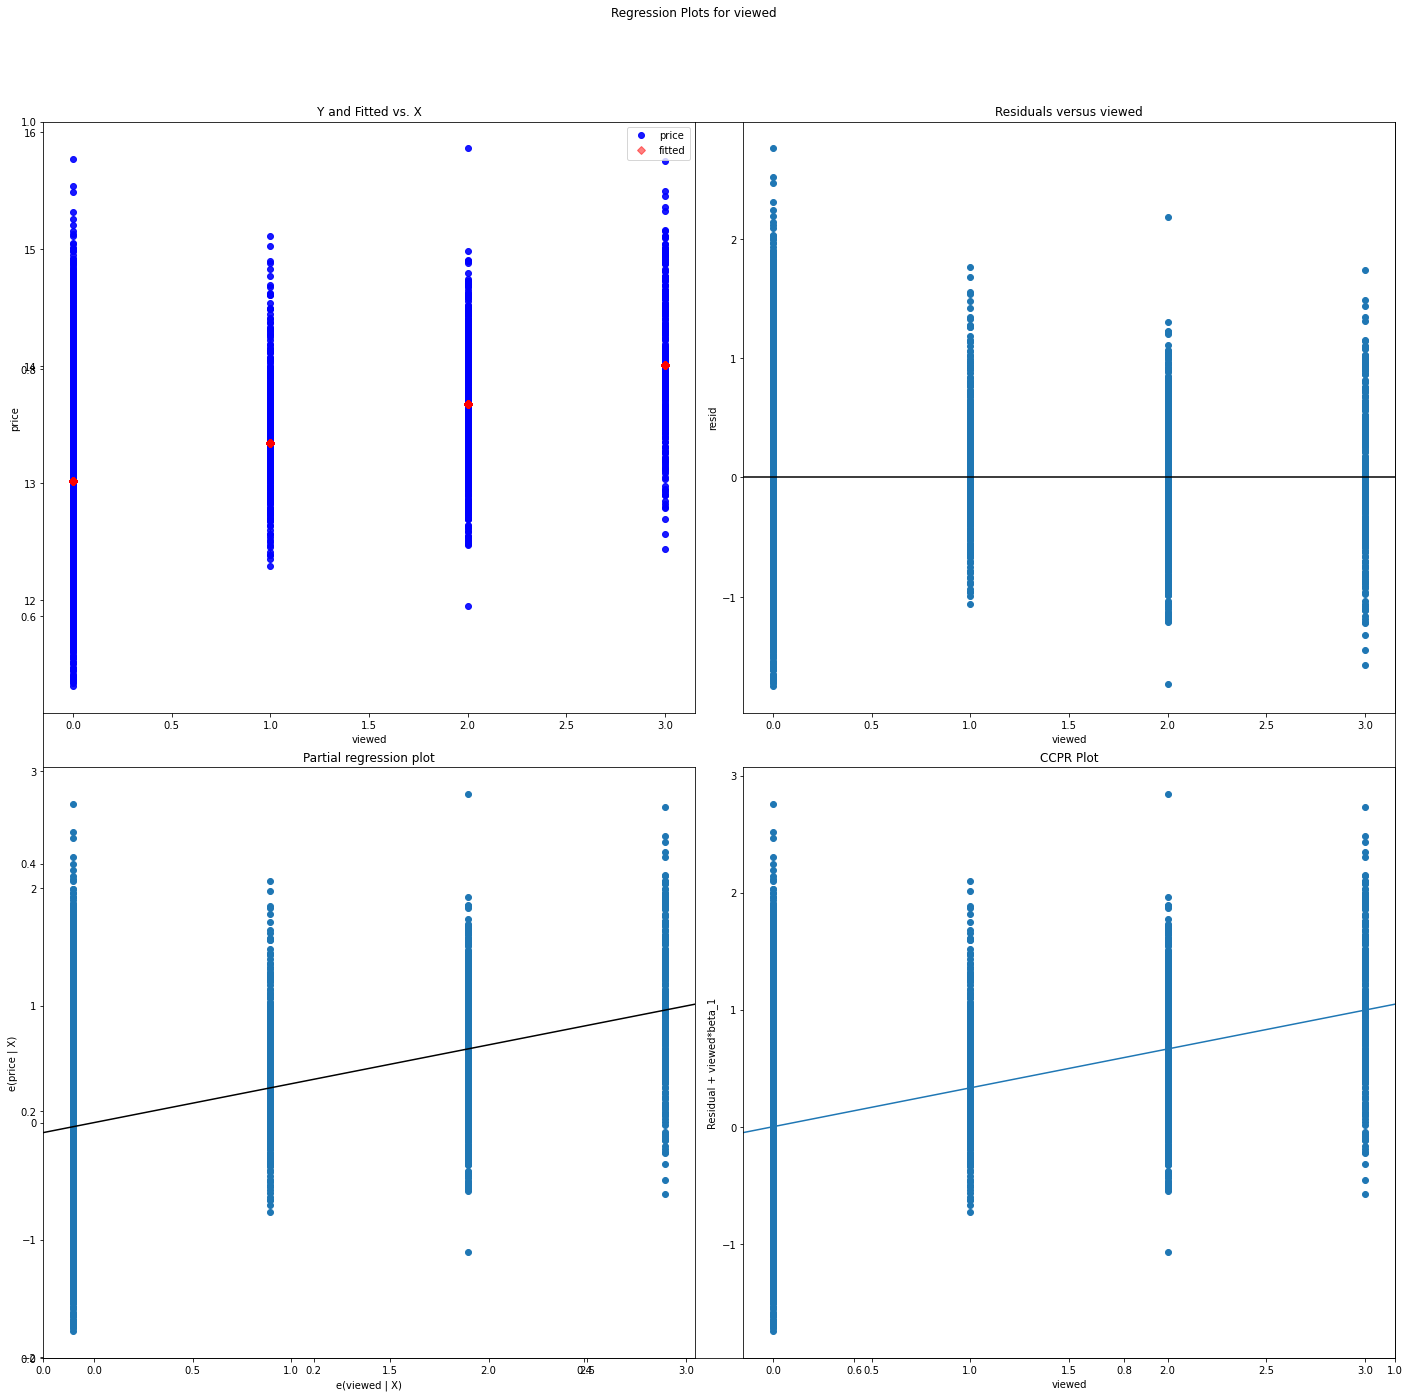

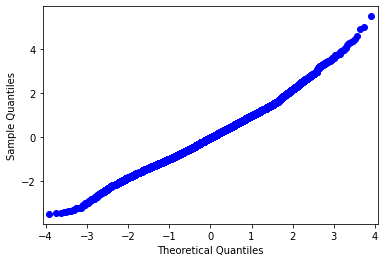

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. bathrooms


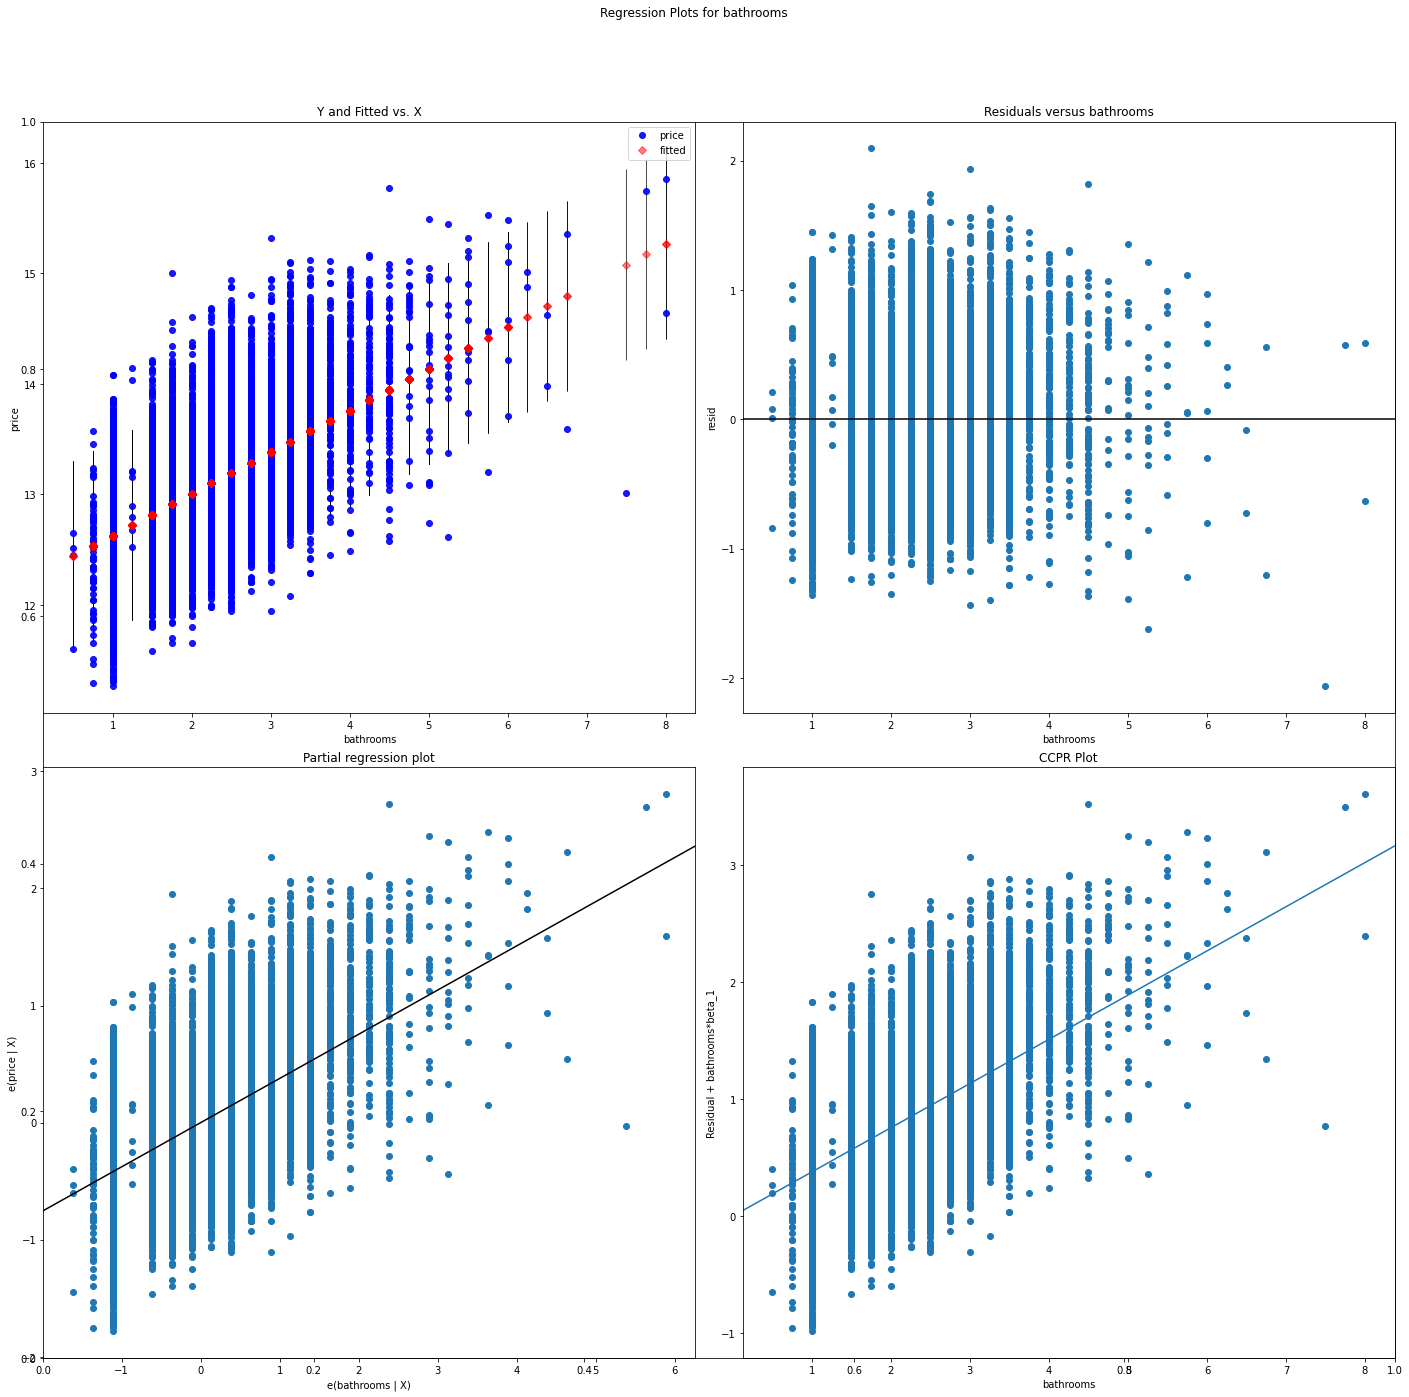

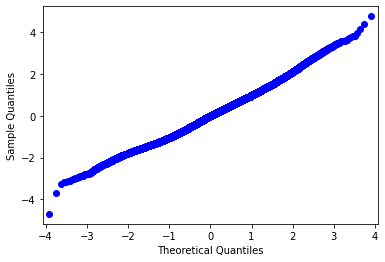

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. graded


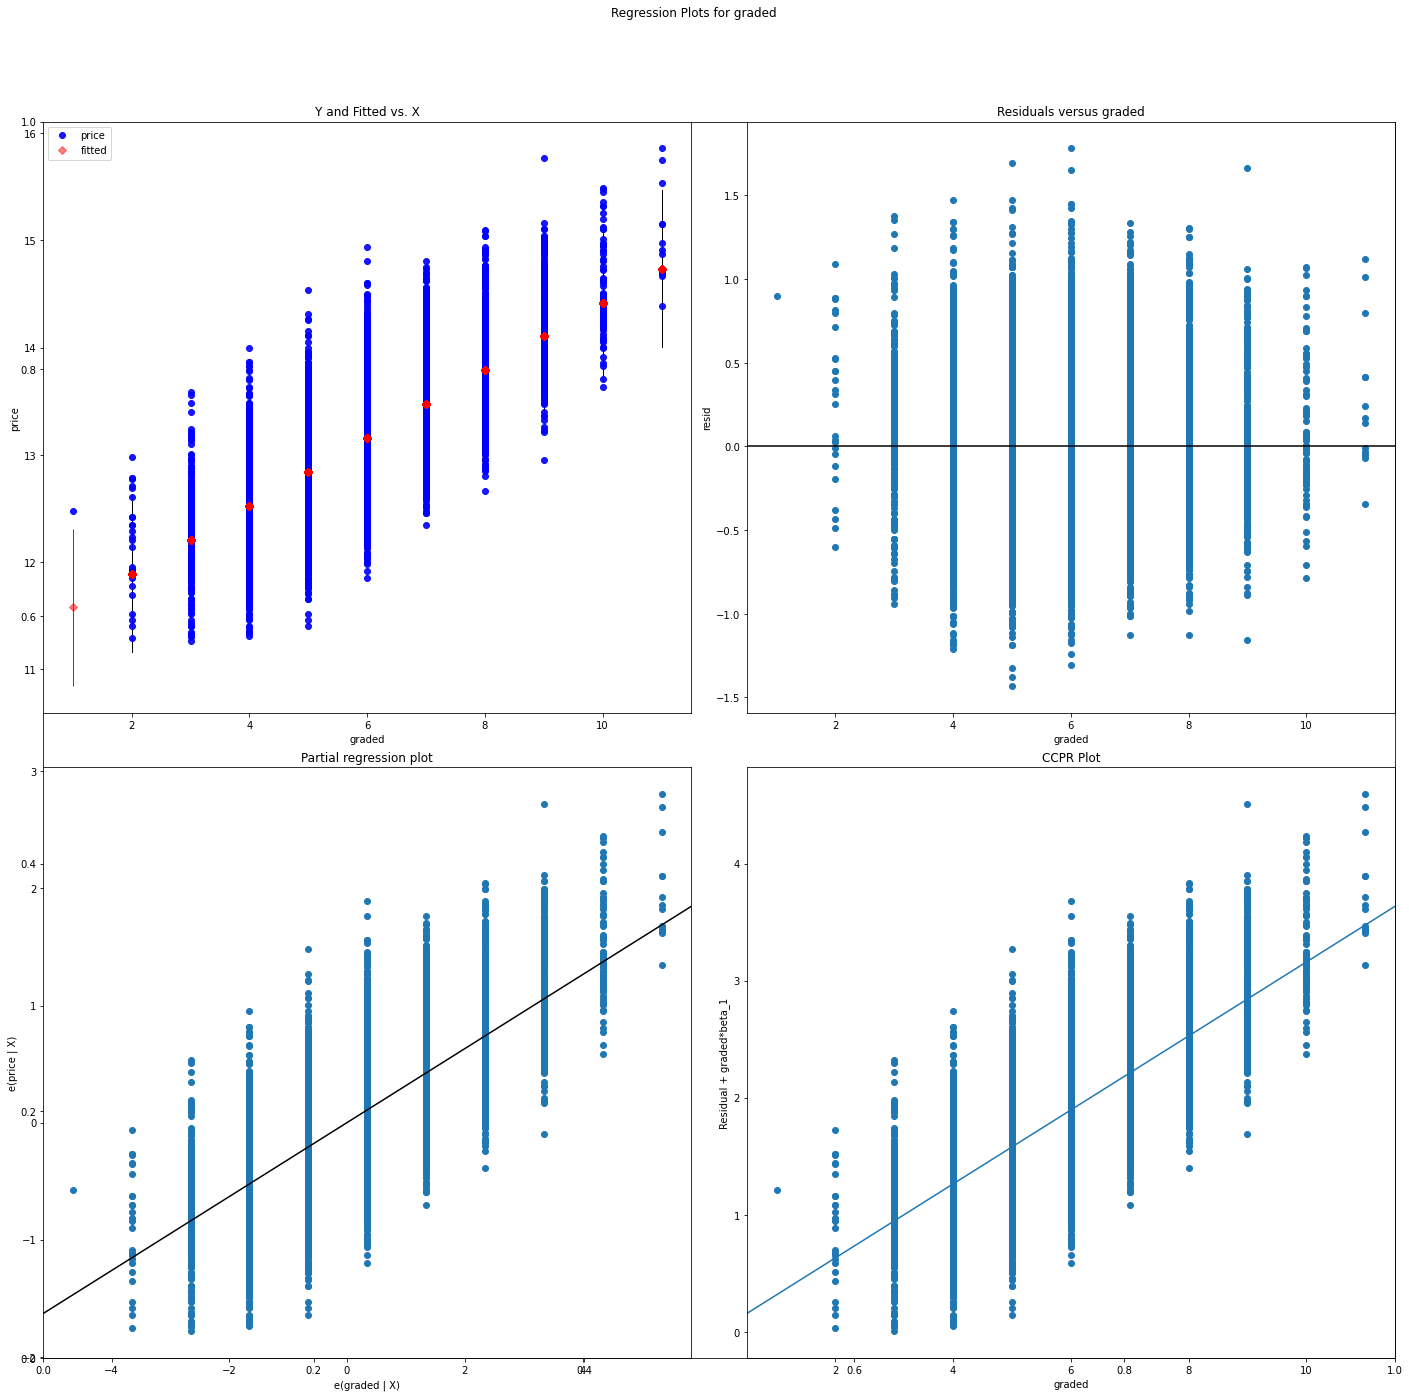

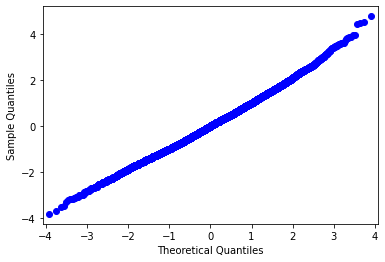

Press enter to continue


In [15]:
results2=[]
for idx, column in enumerate(housingmodel2.columns):
    print('Housing Dataset - Regression Analysis for Price vs. {}'.format(column))
    f=f'price~{column}'
    model=smf.ols(formula=f, data=housingmodel2).fit()
    fig, axes = plt.subplots(figsize=(20,20))
    fig=sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig=sm.graphics.qqplot(model.resid, dist=stats.norm, fit=True)
    plt.show()
    results2.append([column, model.rsquared, model.params[0],model.pvalues[1], sms.jarque_bera(model.resid)[0]])
    input('Press enter to continue')

Plotting the residuals out confirms that our continuous variables are now normalized. The heteroscedasticity we observed in the prior model has been reduced, and the spread of residuals across the X axis looks more even. The QQ plots also show the trademark 45 degree straight line now. Further improvement on this model can be achieved by addressing issues that may arise from multicollinearity in our variables.

### Model 3

Prior to creating the first model, correlation between some of the predictors was observed. These issues can be addressed  by replacing variables where necessary. Below, the correlation heatmap is created with the current variables in the model.

<AxesSubplot:>

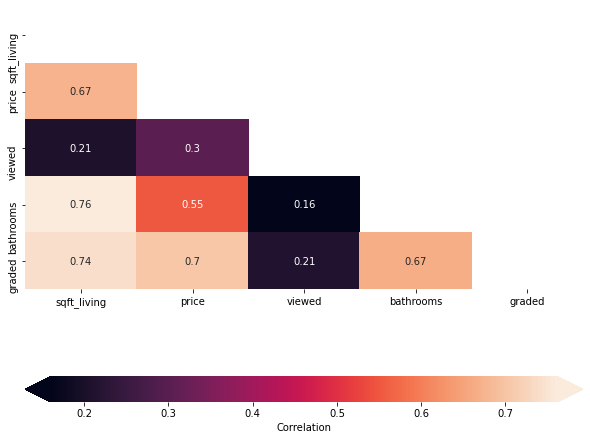

In [16]:
correlation=housingmodel2.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    # Specifies the data to be plotted
    data=correlation,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(correlation, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)


'sqft_living' has a high correlation to the grade and bathroom columns, which is proven to be problematic. Multicollinearity is inherently a problem as performing linear regression assumes that unit changes in each individual predictor has no effect on the others. Since 'sqft_living' is highly correlated with more than one variable (correlation factor over .7), it can be replaced with a variable that has the next highest correlation with 'price', 'bathrooms' (.31 from the initial chart). 

Despite making the decision to remove 'sqft_living' from the model, it is still known that it has a noticably high correlation with pricing. More details regarding this choice will be expanded on in the final model's results.

In [58]:
housingmodel3=housingmodel2.copy()

housingmodel3=housingmodel3.drop(['sqft_living'], axis=1)
bedroomscol=housingnumer[['bedrooms']]
housingmodel3=pd.concat([housingmodel3,bedroomscol],axis=1)
housingmodel3.head()

,price,viewed,bathrooms,graded,bedrooms
0,12.309982,0.0,1.00,5,3
1,13.195614,0.0,2.25,5,3
2,12.100712,0.0,1.00,4,2
3,13.311329,0.0,3.00,5,4
4,13.142166,0.0,2.00,6,3


<AxesSubplot:>

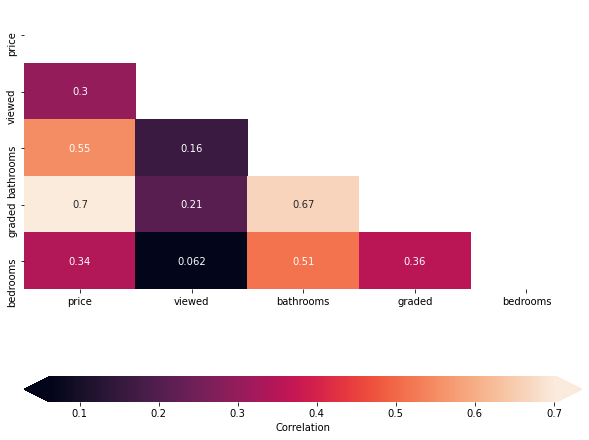

In [59]:
correlation=housingmodel3.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    data=correlation,
    mask=np.triu(np.ones_like(correlation, dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

When rebuilding the heatmap, none of the variables have major observable correlation with each other (none over .7). The new data is now fed into the next model.

In [60]:
outcome='price'
columns=['viewed','bathrooms','bedrooms','graded']
predictors='+'.join(columns)
f=outcome+'~'+predictors
model3=smf.ols(formula=f,data=housingmodel3).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     6220.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        19:33:04   Log-Likelihood:                -8514.9
No. Observations:               21597   AIC:                         1.704e+04
Df Residuals:                   21592   BIC:                         1.708e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2785      0.014    823.060      0.000      11.252      11.305
viewed         0.1751      0.005     33.593      0.000       0.165       0.185
bathrooms      0.0725      0.005     15.626      0.000       0.063       0.082
bedrooms       0.0425      0.003     13.808      0.000       0.036       0.049
graded         0.2570      0.003     91.133      0.000       0.252       0.263
==============================================================================
Omnibus:                       50.342   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.605
Skew:                           0.116   Prob(JB):                     1.03e-11
Kurtosis:                       2.953   Cond. No.                         40.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Jarque-Bera went down further, and the R-squared value went down inherently, as a highly correlated variable to 'price' was replaced with a variable with a lower correlation. While the R-squared value is the main metric of importance, concern also lies in the validity of the coefficients for each predictor in the regression.  

Housing Dataset - Regression Analysis for Price vs. price


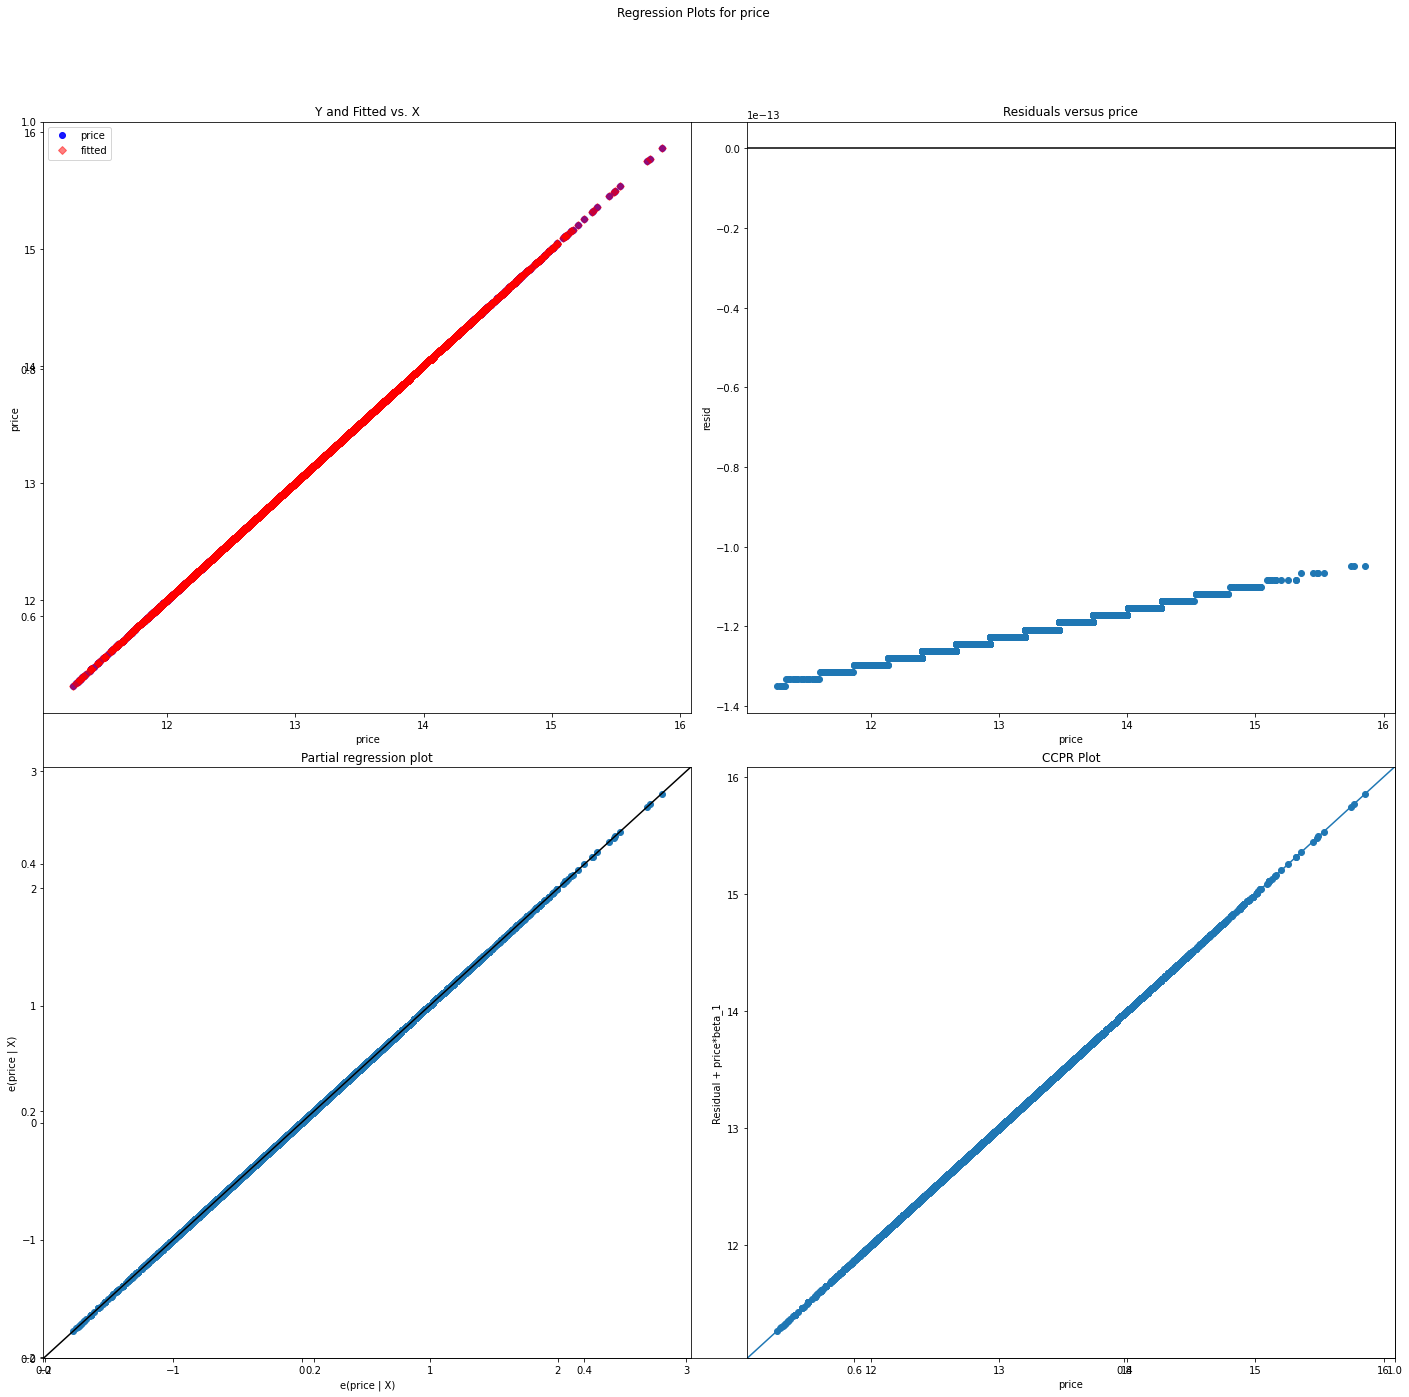

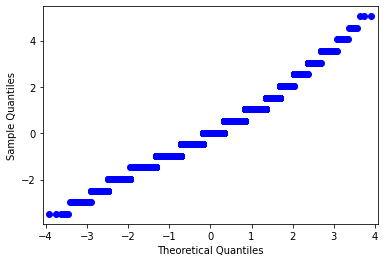

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. viewed


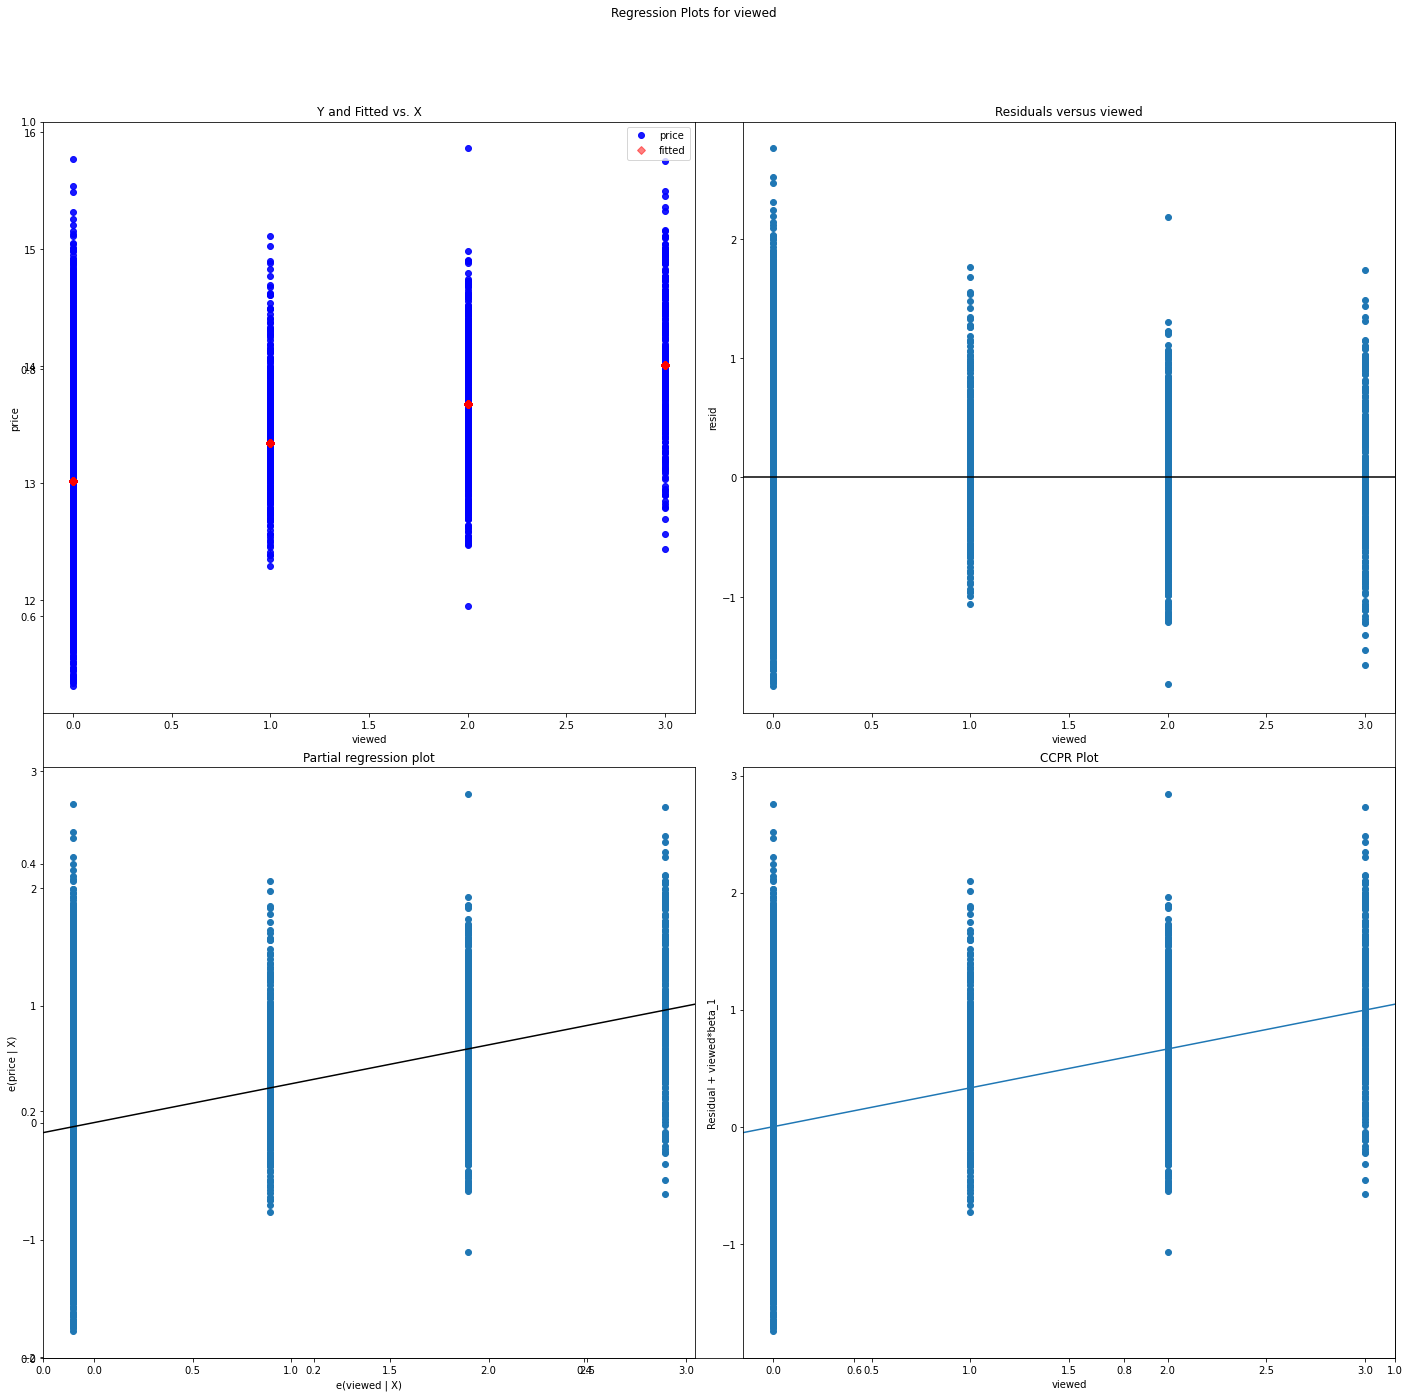

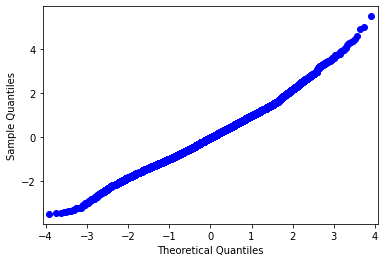

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. bathrooms


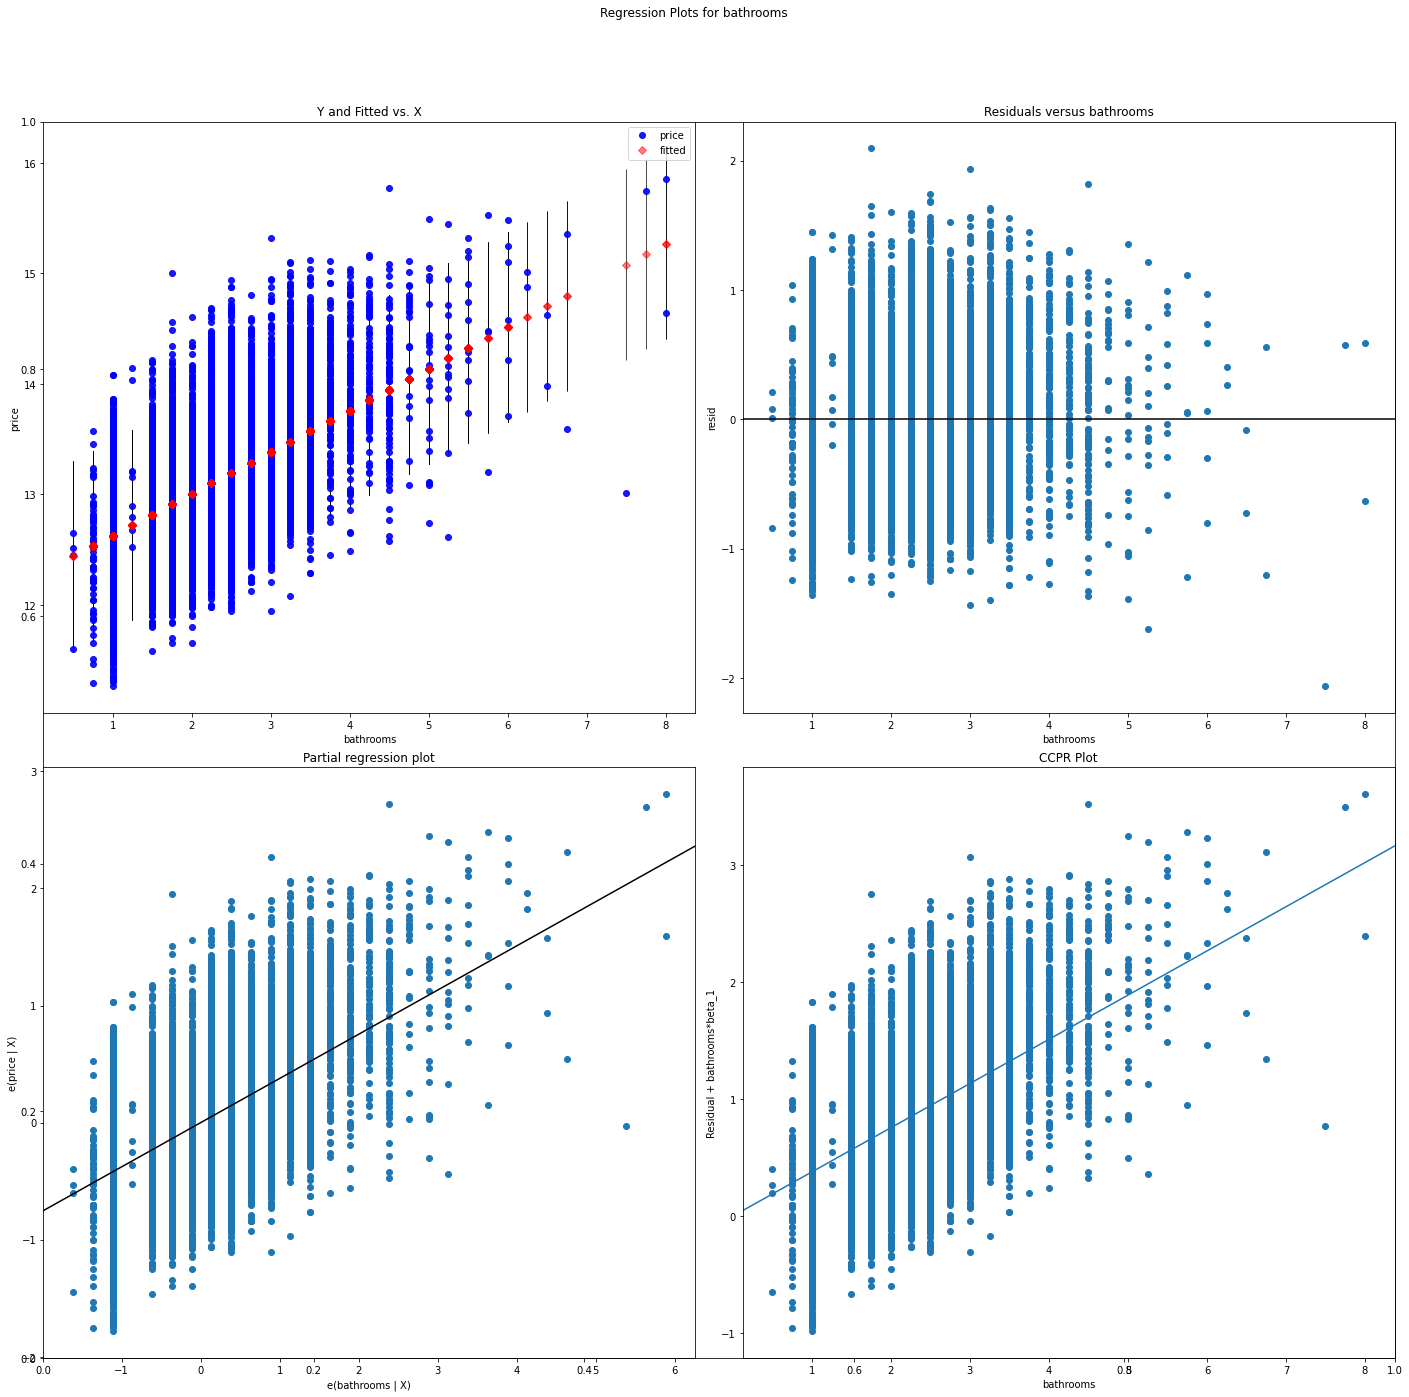

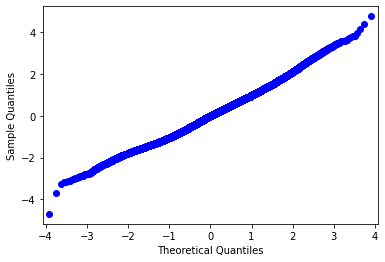

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. graded


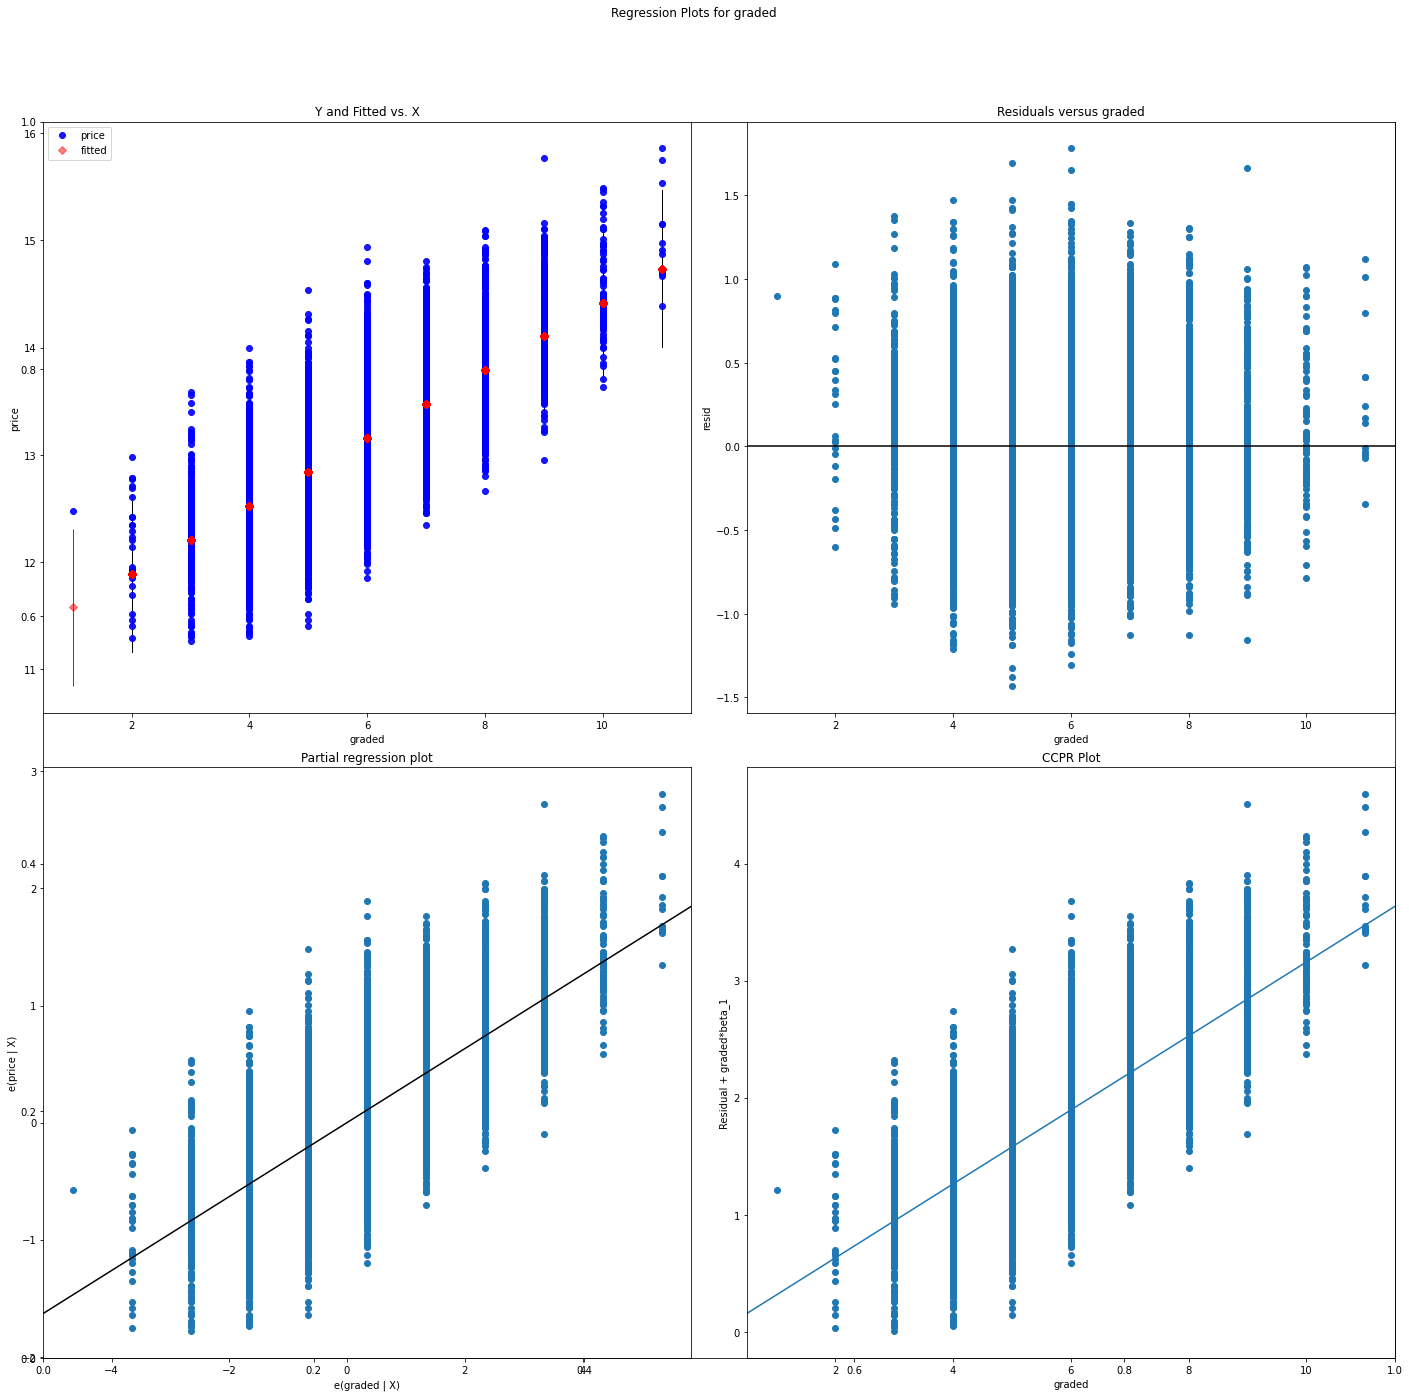

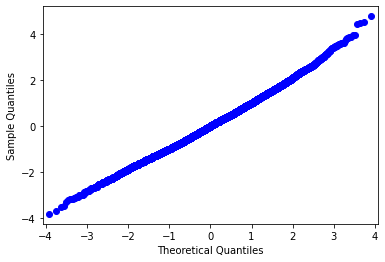

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. bedrooms


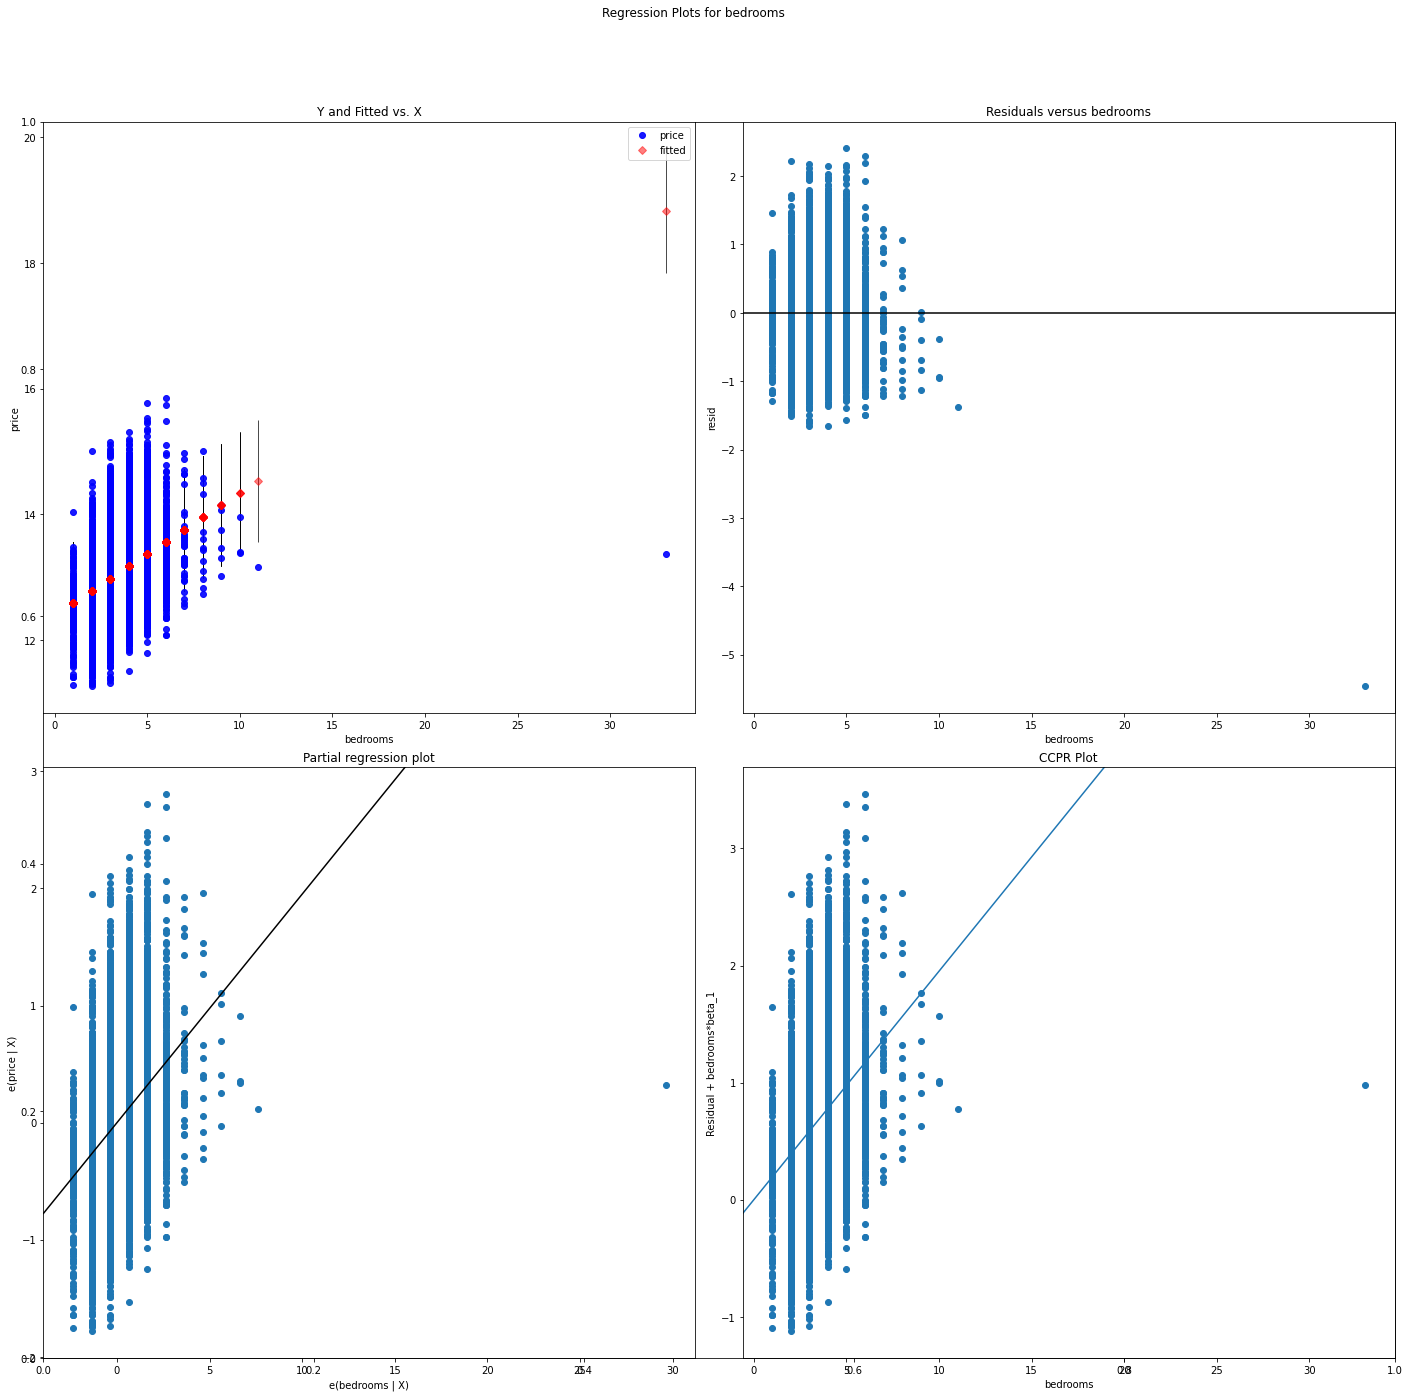

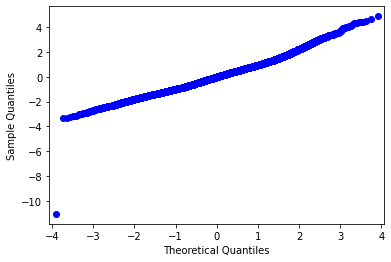

Press enter to continue


In [20]:
results3=[]
for idx, column in enumerate(housingmodel3.columns):
    print('Housing Dataset - Regression Analysis for Price vs. {}'.format(column))
    f=f'price~{column}'
    model=smf.ols(formula=f, data=housingmodel3).fit()
    fig, axes = plt.subplots(figsize=(20,20))
    fig=sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig=sm.graphics.qqplot(model.resid, dist=stats.norm, fit=True)
    plt.show()
    results3.append([column, model.rsquared, model.params[0],model.pvalues[1], sms.jarque_bera(model.resid)[0]])
    input('Press enter to continue')

Adding the 'bathrooms' variable created issues within model residuals, seen when looking at the output QQ plot for 'bedrooms'. In order to increase the R-squared value and account for these new issues, next, adjustments can be performed to deal with the outliers within each of the predictors.


### Model 4

In [61]:
housingmodel4=housingmodel3.copy()

housingmodel4.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

Checking over the value counts in the 'bedrooms' column,  there is 1 home in the dataset with 33 bedrooms. This outlier may be a result of user input error, but solely including this value can throw off the model performance.  

In [23]:
housingmodel4=housingmodel4[housingmodel4['bedrooms']!=33]
housingmodel4.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

Similarly with the 'bathrooms' column, the unharmonized amount of non-integers may cause additional noise in the dataset, reducing the R2 value further. To mitigate this, the 'bathrooms' values are rounded up/down to the nearest whole number.

In [24]:
housingmodel4.graded.value_counts()

5     8973
6     6065
7     2615
4     2038
8     1134
9      399
3      242
10      89
2       27
11      13
1        1
Name: graded, dtype: int64

Low-grade homes within the dataset may also be contributors to the noise, and could be throwing off the R-squared values as well. Homes in a state of severe disrepair, which are not near code standards according to the King County glossary, should not contribute in our overall dataset where pricing is concerned. The bulk of the data seems to lie within grade 4 and above anyways, so 'grade' values of 1-3 are removed. 

In [25]:
housingmodel4=housingmodel4[housingmodel4.graded>=4]
housingmodel4.graded.value_counts()

5     8973
6     6065
7     2615
4     2038
8     1134
9      399
10      89
11      13
Name: graded, dtype: int64

In [27]:
outcome='price'
columns=['viewed','bathrooms','bedrooms','graded']
predictors='+'.join(columns)
f=outcome+'~'+predictors
model4=smf.ols(formula=f,data=housingmodel4).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     5973.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:39:45   Log-Likelihood:                -8329.8
No. Observations:               21326   AIC:                         1.667e+04
Df Residuals:                   21321   BIC:                         1.671e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2538      0.014    783.531      0.000      11.226      11.282
viewed         0.1731      0.005     33.128      0.000       0.163       0.183
bathrooms      0.0697      0.005     14.915      0.000       0.061       0.079
bedrooms       0.0455      0.003     14.192      0.000       0.039       0.052
graded         0.2605      0.003     90.121      0.000       0.255       0.266
==============================================================================
Omnibus:                       48.113   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.274
Skew:                           0.113   Prob(JB):                     3.29e-11
Kurtosis:                       2.942   Cond. No.                         42.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Housing Dataset - Regression Analysis for Price vs. price


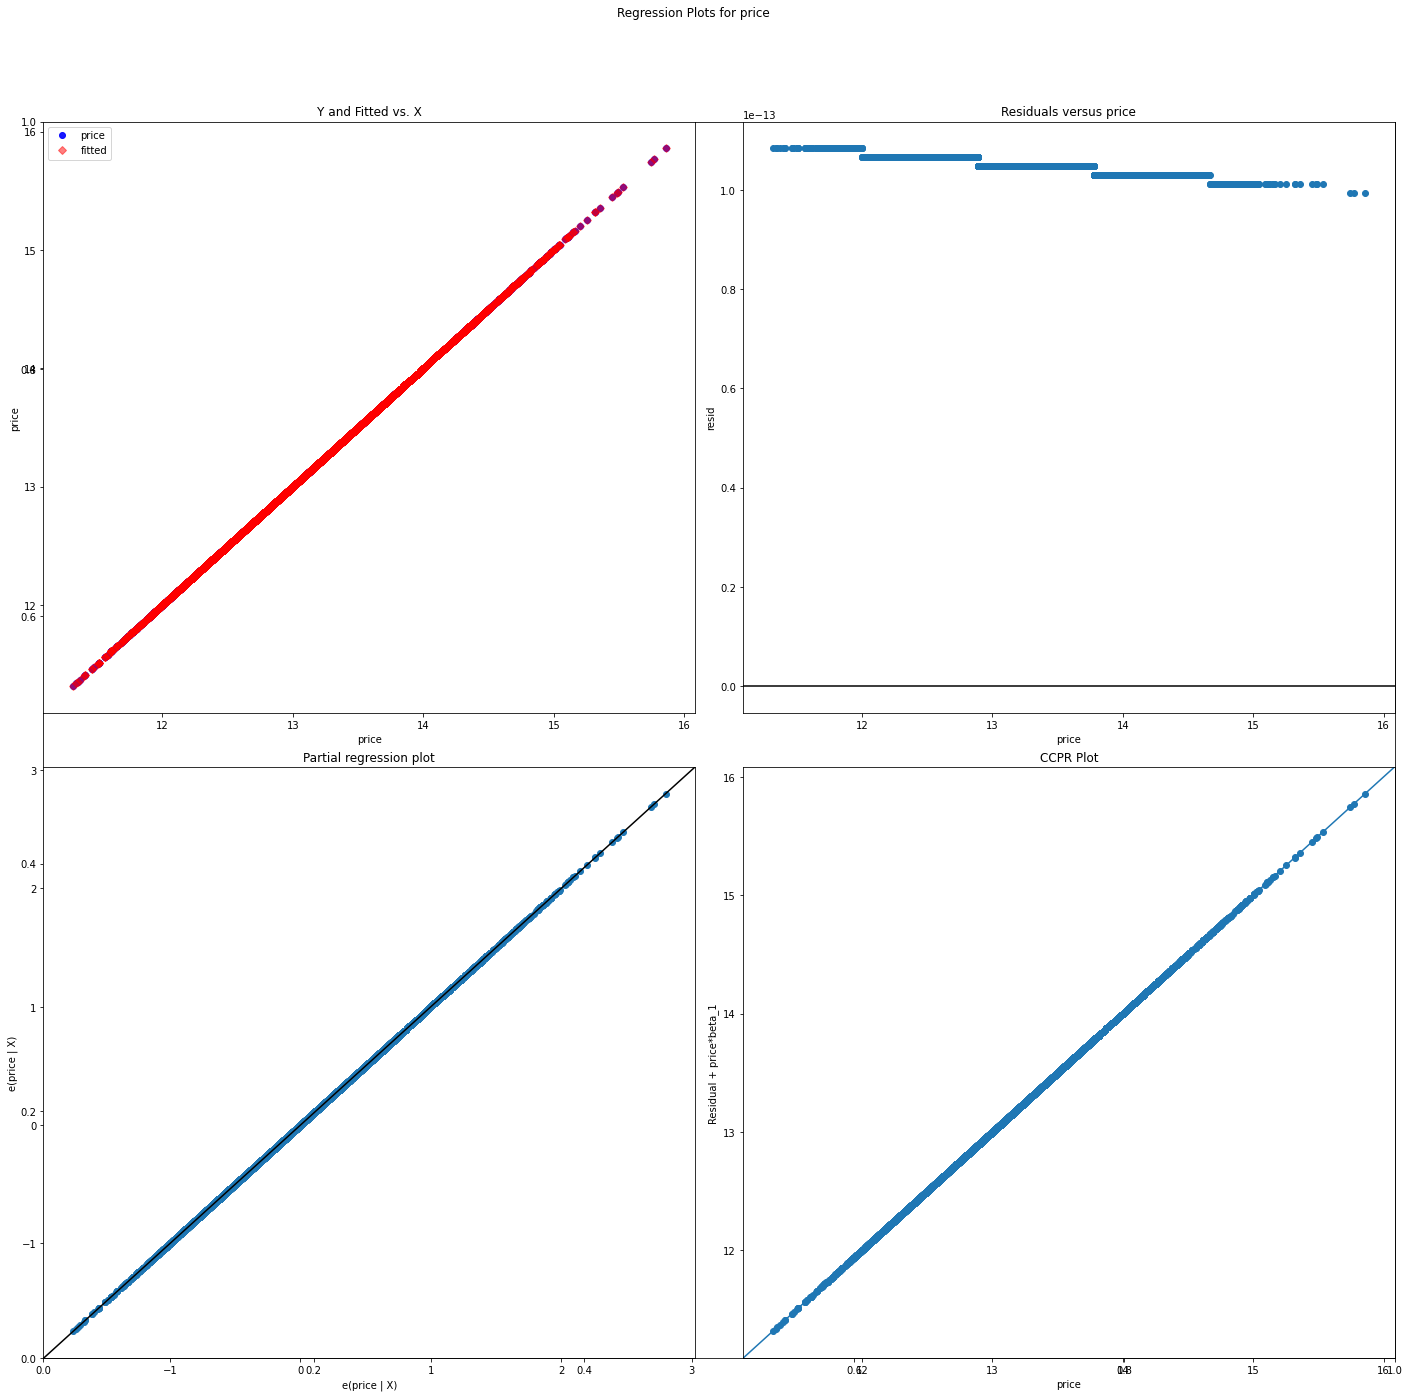

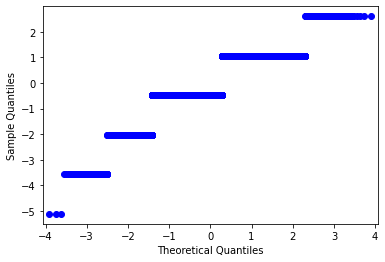

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. viewed


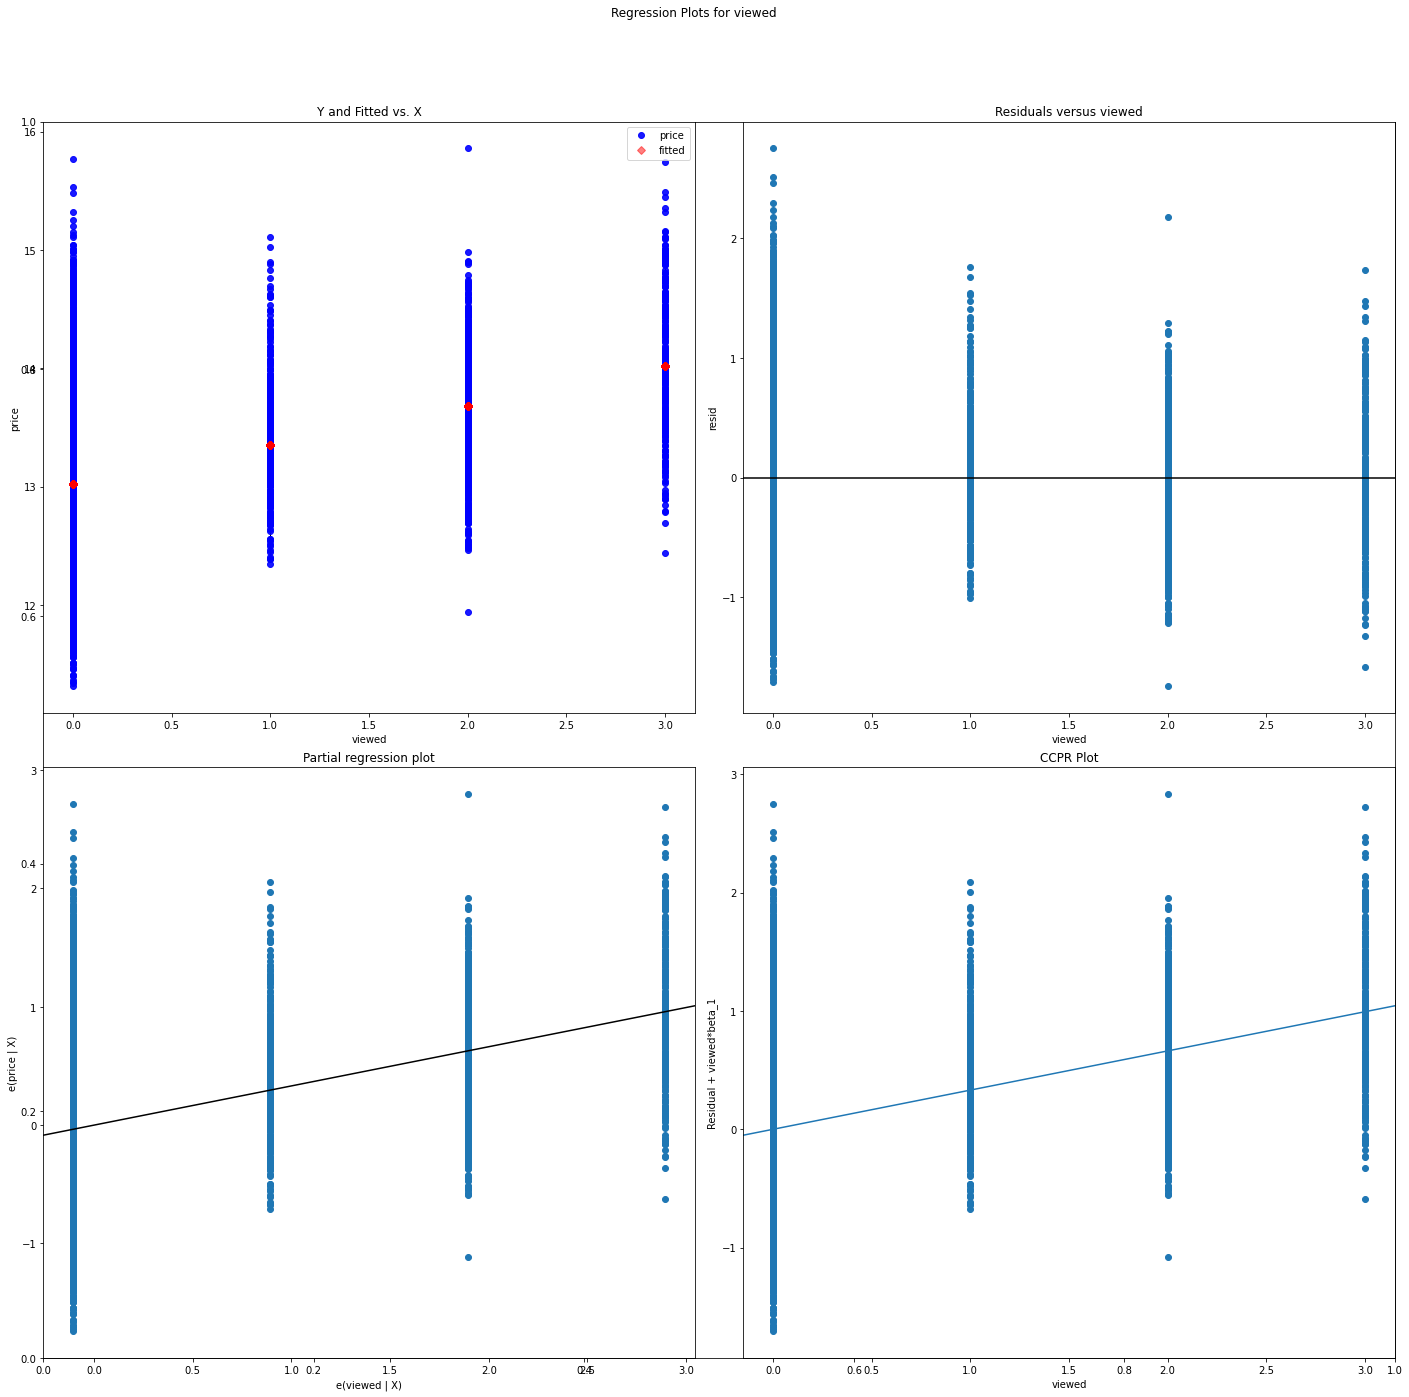

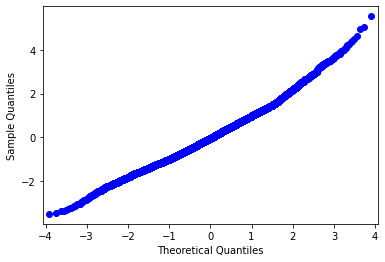

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. bathrooms


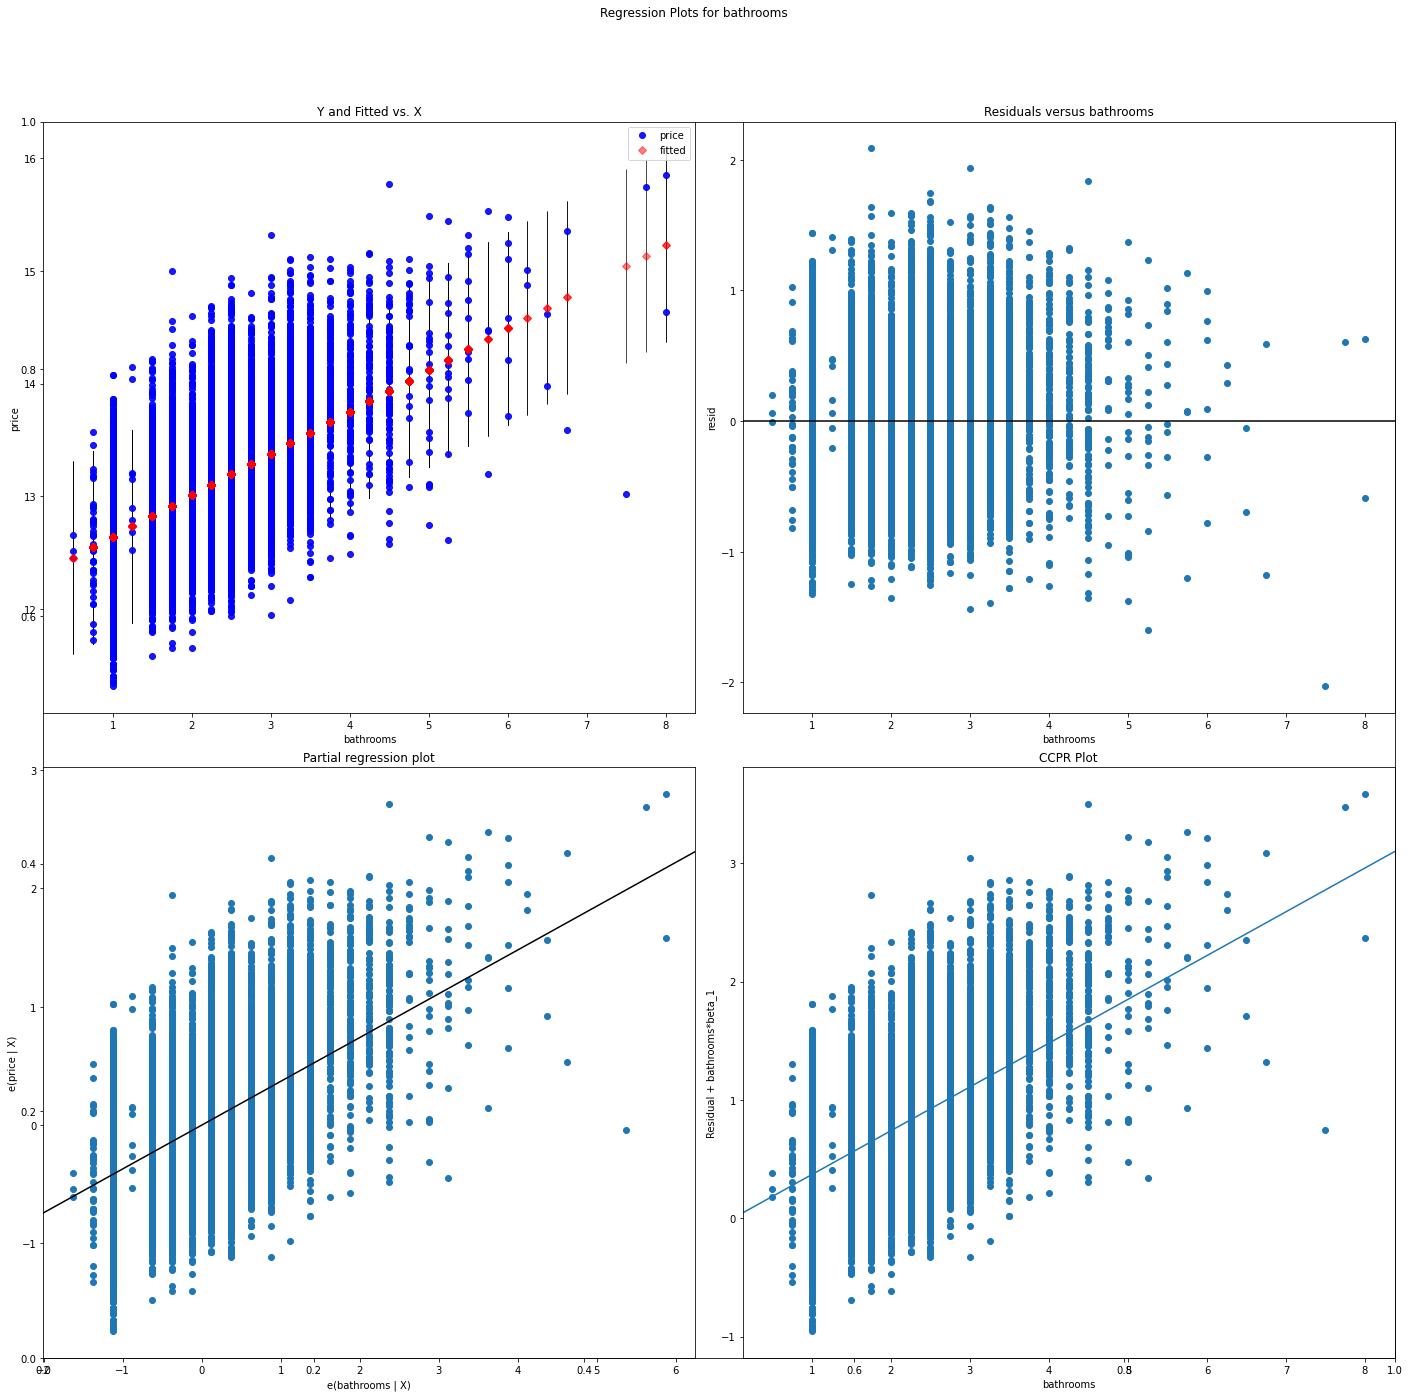

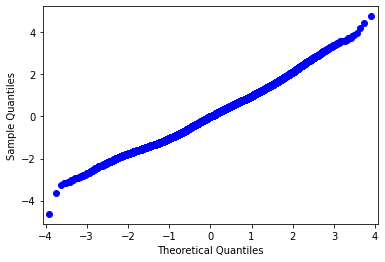

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. graded


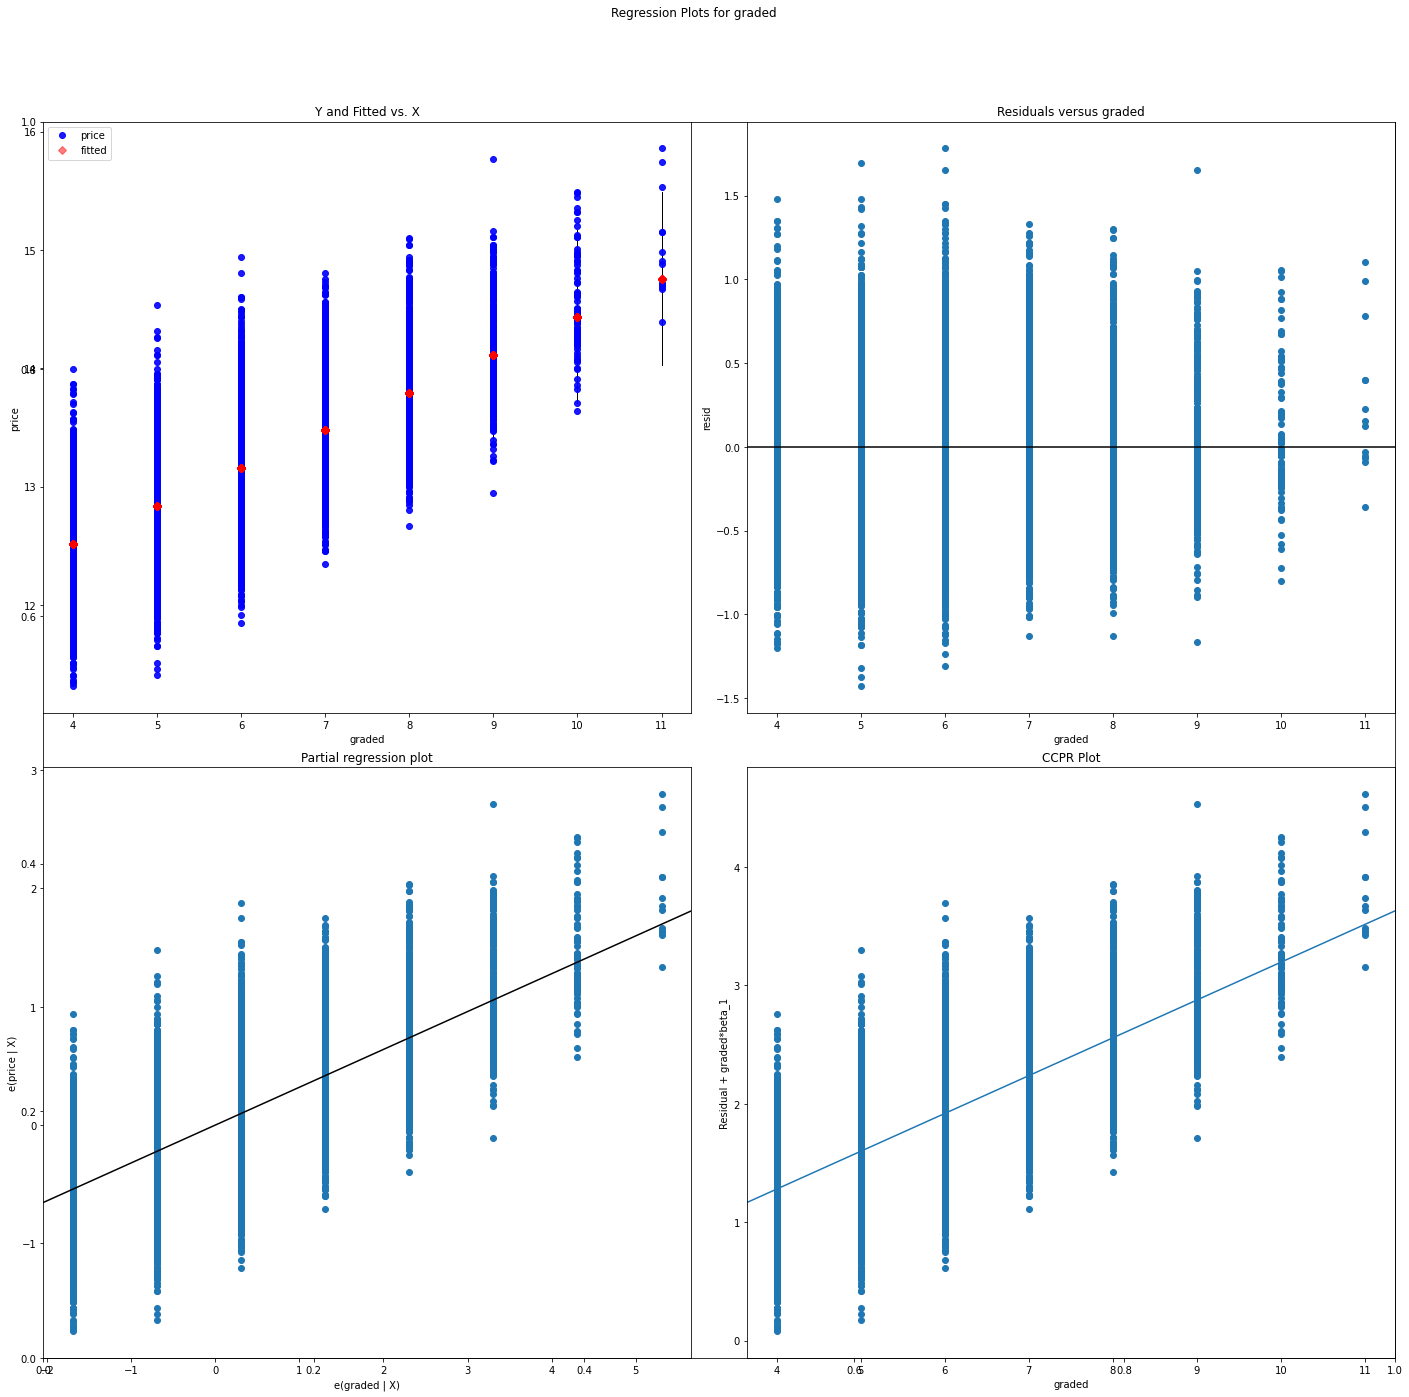

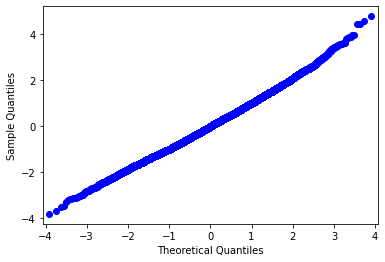

Press enter to continue
Housing Dataset - Regression Analysis for Price vs. bedrooms


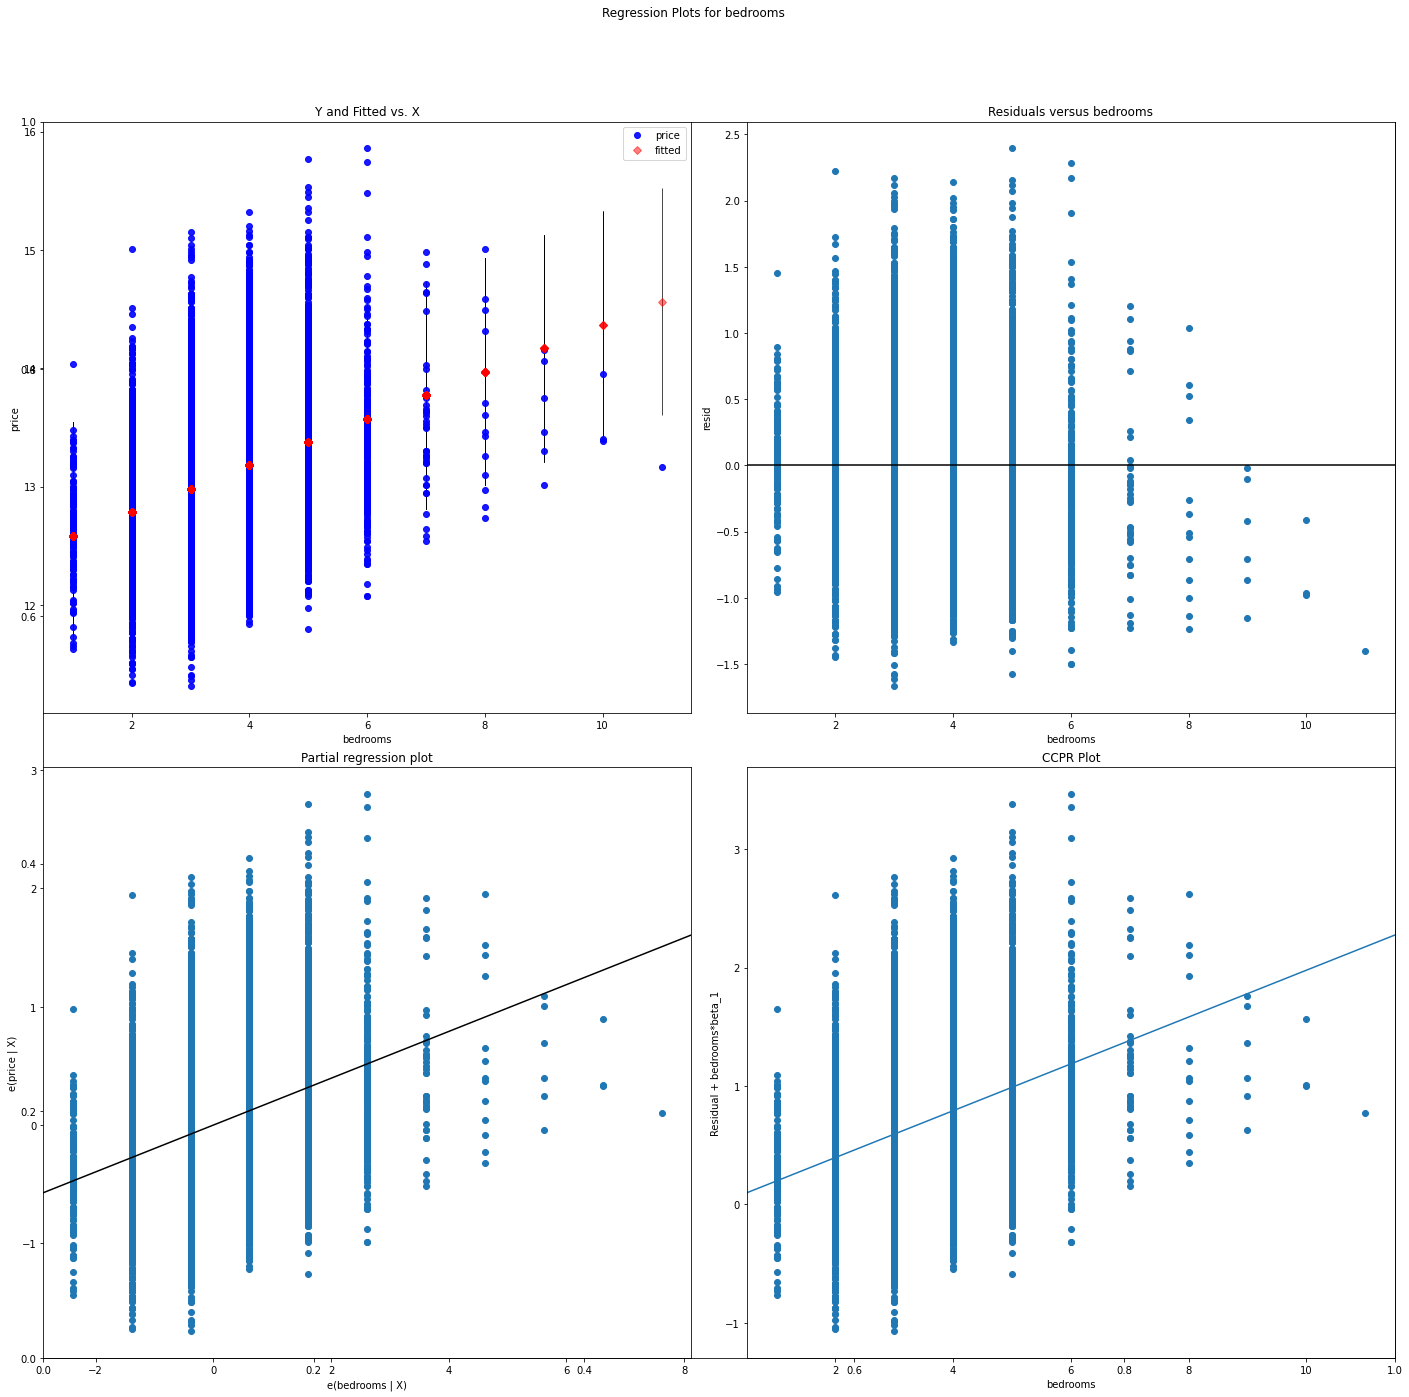

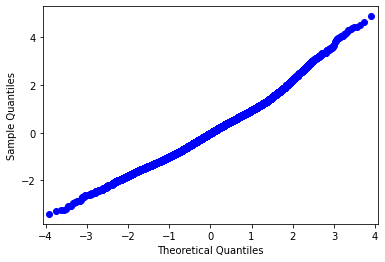

Press enter to continue


In [28]:
results4=[]
for idx, column in enumerate(housingmodel4.columns):
    print('Housing Dataset - Regression Analysis for Price vs. {}'.format(column))
    f=f'price~{column}'
    model=smf.ols(formula=f, data=housingmodel4).fit()
    fig, axes = plt.subplots(figsize=(20,20))
    fig=sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig=sm.graphics.qqplot(model.resid, dist=stats.norm, fit=True)
    plt.show()
    results3.append([column, model.rsquared, model.params[0],model.pvalues[1], sms.jarque_bera(model.resid)[0]])
    input('Press enter to continue')

Jarque-Bera improved slightly with these changes and the residual errors look better now that the outliers were removed. 

### Accounting for Interactions

In an effort to further improve the R-squared value, the interaction between different variables, outside of an additive means should be accounted for. To start, the set is split into predictors and outcome variable, then the baseline R-squared score is re-calculated using KFold validation. 

In [45]:
housingmodelinter=housingmodel4.copy()
X=housingmodelinter.drop(['price'],axis=1)
y=housingmodelinter[['price']]

regression=LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X, y, scoring='r2', cv=crossvalidation))

baseline

0.527554331125162

Each pair combination of predictors is then assessed to understand if the addition of a interaction factor betweeen the two would increase the baseline R-squared value. 
The top resulting scores from each added potential interaction are then printed. 

In [47]:
interactions=[]

combos=combinations(X.columns,2)

data=X.copy()

for i, (a,b) in enumerate(combos):
    data['interaction']=data[a]*data[b]
    score=np.mean(cross_val_score(regression,data,y, scoring='r2', cv=crossvalidation))
    if score>baseline:
        interactions.append((a,b,round(score,3)))
        
print('Top interactions: %s'%sorted(interactions, key=lambda inter: inter[2], reverse=True)[0:5])

Top interactions: [('bathrooms', 'graded', 0.529), ('bathrooms', 'bedrooms', 0.529), ('graded', 'bedrooms', 0.529), ('viewed', 'graded', 0.528), ('viewed', 'bedrooms', 0.528)]


As seen above, the addition of an interaction between grade/bedrooms increase the R-squared slightly, so it is added to the current model as a new interaction column.

In [48]:
housingmodelinter['gradebed']=housingmodelinter['graded']*housingmodelinter['bedrooms']

housingmodelinter.head()

,price,viewed,bathrooms,graded,bedrooms,gradebed
0,12.309982,0.0,1.00,5,3,15
1,13.195614,0.0,2.25,5,3,15
2,12.100712,0.0,1.00,4,2,8
3,13.311329,0.0,3.00,5,4,20
4,13.142166,0.0,2.00,6,3,18


In [49]:
outcome='price'
columns=['viewed','bathrooms','bedrooms','graded','gradebed']
predictors='+'.join(columns)
f=outcome+'~'+predictors
model5=smf.ols(formula=f,data=housingmodelinter).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     4807.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:53:01   Log-Likelihood:                -8295.8
No. Observations:               21326   AIC:                         1.660e+04
Df Residuals:                   21320   BIC:                         1.665e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.6296      0.048    243.443      0.000      11.536      11.723
viewed         0.1713      0.005     32.805      0.000       0.161       0.181
bathrooms      0.0700      0.005     15.011      0.000       0.061       0.079
bedrooms      -0.0603      0.013     -4.560      0.000      -0.086      -0.034
graded         0.1921      0.009     21.869      0.000       0.175       0.209
gradebed       0.0189      0.002      8.247      0.000       0.014       0.023
==============================================================================
Omnibus:                       40.396   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.530
Skew:                           0.104   Prob(JB):                     1.58e-09
Kurtosis:                       2.950   Cond. No.                         455.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With the addition of the interaction variables, the R-squared value increased slightly, and Jarque-Bera decreased slightly.
The next step is assessing the model to ensure overfitting within the model is not occurring. 


### Train/Test Split

Now that the model is essentially complete, a train-test split should be performed in order to understand how the model performs with new data in the mix, in the event that more data gets added to the overall set. 

In [50]:
housingmodelfinal=housingmodelinter.copy()

fX=housingmodelfinal.drop(['price'],axis=1)
fy=housingmodelfinal[['price']]

Xtrain, Xtest, Ytrain, Ytest= train_test_split(fX,fy,test_size=.2, random_state=1312)

In [42]:
linreg=LinearRegression()
linreg.fit(Xtrain,Ytrain)

yhattrain=linreg.predict(Xtrain)
yhattest=linreg.predict(Xtest)

trainresid=yhattrain-Ytrain
testresid=yhattest-Ytest

trainmse=mean_squared_error(Ytrain,yhattrain)
testmse=mean_squared_error(Ytest,yhattest)

print(trainmse)
print(testmse)

0.12771261384502436
0.1268359712814621


In [51]:
mse=make_scorer(mean_squared_error)
cv_5_results=cross_val_score(linreg,fX,fy,cv=5, scoring=mse)

print(cv_5_results)
print(cv_5_results.mean())

[0.13356138 0.12939035 0.13124805 0.13139987 0.1125493 ]
0.12762979043118106


Thankfully, the cross-fold validation performed on the data lines up similarly to initial train/test results. That being said, the model is not overfit with the training data.

# Regression Results

There are several factors that go into determining a valuation of a home. In order to find the ideal predictors that are critical to the determination of home price, the performed analysis/regression results of the King County home dataset revealed the scale/importance of several of these fields. While the overall factors are helpful in determining the scale and effect of variables on sale price, the model as a whole does not completely reflect the whole dataset. The regression metric of success, R-squared value, would end up being closer to 1. 

That being said, the model still revealed the key factors that have the highest effect on price. In the bottom half of the model summary seen below, the 'coef' column, aligning with each of the final variables, shows the numerical importance of the dependent price variable.

As a note, when evaluating a theoretical price using the model, these coefficients represent the percent increase in price Y with each 'unit' increase of a given X predictor variable. The Intercept value in the coefficient column shows the initial Baseline price estimated that each home has according to the model, stripped of its features. To convert this into a value of interpretation, e^(intercept value), done to inverse the initial log transformation to get a baseline price of. In this case, the baseline home value is $112,307.

In [52]:
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     4807.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:58:34   Log-Likelihood:                -8295.8
No. Observations:               21326   AIC:                         1.660e+04
Df Residuals:                   21320   BIC:                         1.665e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.6296      0.048    243.443      0.000      11.536      11.723
viewed         0.1713      0.005     32.805      0.000       0.161       0.181
bathrooms      0.0700      0.005     15.011      0.000       0.061       0.079
bedrooms      -0.0603      0.013     -4.560      0.000      -0.086      -0.034
graded         0.1921      0.009     21.869      0.000       0.175       0.209
gradebed       0.0189      0.002      8.247      0.000       0.014       0.023
==============================================================================
Omnibus:                       40.396   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.530
Skew:                           0.104   Prob(JB):                     1.58e-09
Kurtosis:                       2.950   Cond. No.                         455.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Recommendations/Conclusion


### Note Regarding the 'sqft_living' Field

In initial models, 'sqft_living' was perceived to be the most correlated to 'price', which makes sense as increasing the overall living space would increase the amount a home is worth. Its coefficient seen in the results of linear regression was the highest amongst the other variables as well.

In the end, it was not included in the regression due to its multicollinearity with the other variables, 'grade' and 'bedrooms', which made prior regresion results unreliable. The multicollinearity observed makes sense, as the more space/occupants a home has, the higher amount of bedrooms it would likely have, and the higher grade of construction necessary to build it. 

__That being said, living space, or 'sqft_living' is a major contributing factor in a home's resulting sale price.__ If a home owner's objective is to increase sale price to a great degree, they should consider increasing the living space. All homes within the dataset are fully built, so the recommendation would require major foundational, structural, and financial investment. 


### Most Important Variables for increasing Price

__From the final regression model, the variables that were most impactful in resulting sale price were (in order): Grade (represented as graded), View (represented as viewed), and Bedrooms (represented as bedrooms). These results are unsurprising as explained below.__

__Grade is seen to increase resulting price by 19.2% with each unit increase.__
The grade of a home relates to its construction and design. Homes that were designed by renowned artists/architects, or for famous individuals more than likely have special features that drive up the overall valuation. Redesigns/renovations with emphasized focus on the quality of its features will have a positive impact on its resulting price.


__View is seen to increase price by a percentage of 17.1% with each unit increase.__
The view a home has is especially important. Obviously, not much improvement can be done on a built home in terms of its location and view. However, the placement of windows could be optimized, further capitalizing on a home's location/view. Changing the window style, or having floor-to-ceiling glass panes to replace walls may greatly improve a home's price.

__Bathrooms are seen to increase price by a percentage of 7% with each unit increase.__
The amount of bathrooms (and similarly bedrooms) a home has is inherently correlated with its square footage. The more rooms/occupants a home accomodates for, in turn, increases the required amount of bathrooms and resulting price. While being a potential improvement from the lens of condition, bathrooms can be renovated to increase the overall quality of utilities and design. 

While approaching each of these variables for improvement individually would be infeasible, holistic renovations (of varied scales) would encompass all of these categories. There are several home improvement shows on HGTV that make an example of this, such as HGTV ‘s Love It or List It, where current owners have the option to make renovations to a home in order to improve its value. House Hunters, Fixer Upper, Property Brothers, and Flip or Flop, have similar themes of added value.



### Next Steps

Due to the nature of the success metric, the R-squared value, next steps in improving this model would largely involve the addition of variables that help better represent/quantify home pricing.

The latitude and longitude of the home were overlooked within the analysis. the 'view' column, while helpful in emphasizing the location of a home, is quite limited/almost binary in its scope. Next steps would involve mapping the latitude and longitude coordinates via Google Maps API in order to see the home location in relation to geographical features (i.e. Mt. Rainier, Olympics, or the Puget Sound), then applying an adjustment factor based on each landmark for a more nuanced look at home value. 

Similarly, another avenue to explore would be proximity to a certain suburban area or city. With relation to King County, proximity to Seattle would be an inherent upwards driver of cost. Each neighborhood could be represented as predictor variable. This can be analyzed even further through the use of demographics/survey work to identify different social/political communities in the King County area. For example, Brooklyn is known to have a young, progressive, and artsy culture, which may be a draw that can be quantified as an additional variable.

The final point of interest which may be difficult to quantify would be the technological/additional features that a home has. Custom carpentry, unique television displays, in-home surround sound, hot tubs, pools, or outdoor patios could all be additional factors that drive up resulting price. While the grade of the home provides insight into what these features might be, there are no other fields in the dataset that address these additional features. The grade appears to be a catchall variable which is not that descriptive on its own. 